<a href="https://colab.research.google.com/github/jajsmith/COVID19NonPharmaceuticalInterventions/blob/master/npi_context_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NPI-Context: Using intervention context to inform literature search with case study

1. We make it easier to conduct literature search for new interventions in specific environments by incorporating the context for each intervention in our search.

2. We demonstrate this method on a newly constructed dataset of Canadian NPIs. To show the benefit we compare using general Oxford intervention categories as search terms with our method and demonstrate that new relevant research is surfaced.

## Introduction

The competition named "the COVID-19 Open Research Dataset (CORD-19)" has been launched to support experts in the healthcare domain quickly and accurately receive answers to their scientific questions related to coronaviruses. We can take advantage of NLP and ML tools to develop improved ways of finding relevant research to guide policy actions taken by governments and organizations around the world. CORD-19 encompasses 40,000 articles about coronaviruses. For the competition, 10 tasks have been proposed. Each task covers some fundamental questions related to COVID 19. In this submission, we focus on answering the questions in the task related to non-pharmaceutical interventions. In particular we aim to answer:

- What do we know about the effectiveness of non-pharmaceutical interventions?
- What is known about equity and barriers to compliance for non-pharmaceutical interventions?

## Method

### Searching the CORD-19 Dataset

We make use of the [covidex.io](https://covidex.io) project using the Anserini information retrieval toolkit via pyserini. All the documents in CORD-19 are indexed in Lucene. We build off the demonstration notebook found [here](https://colab.research.google.com/drive/1mrapJp6-RIB-3u6FaJVa4WEwFdEBOcTe) to setup the lucene index and search functionality.

Thanks to [Jimmy Lin](https://cs.uwaterloo.ca/~jimmylin/) from the University of Waterloo and [Kyunghyun Cho](http://www.kyunghyuncho.me/) from NYU and their team for building this.

### Building a Dataset of Intervention Events

Policy makers and researchers around the world use literature review to help each team, organization, and country understand the effectiveness of non-pharmaceutical interventions and barriers to compliance *for their specific circumstances*. Observing the leading countries in COVID-19 response like South Korea and China we see drastically different methods used to intervene. **Making use of country-specific context is an important part of improving search quality.**

In order to show the effectivenss of this it is important to have an up-to-date and thorough picture of each countries current interventions and how they are being implemented. One has been created for Canada to use as a case study.

The [howsmyflattening.ca](https://howsmyflattening.ca) team has compiled a dataset of non-pharmaceutical interventions in Canada with 60 intervention labels, 1838 events, and more than 900 unique information sources. Some of the authors of this notebook are contributors to the Canadian non-pharmaceutical interventions dataset. The dataset can be retrieved on Kaggle [here](https://www.kaggle.com/howsmyflattening/covid19-challenges#npi_canada.csv).

### Intervention Context using Topic Modeling

We use Latent Dirichlet Allocation [(Blei, et. al., 2003)](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) to find topics in the full text announcements recorded for all recorded interventions in the input dataset. We then use keywords from these topics to guide search of relevant documents, comparing and augmenting the search results of the labeled interventions themselves. **Crucially, we are not just modeling topics in existing research, but also in actual interventions to understand the relationships between them.**


## Putting it all together - A Case Study in Canada

Below we use Canadian intervention data as a case study for our approach. We apply topic modeling to the intervention text and compare the search results with our baseline approach and show that the context-keyword generation leads to new, relevant results.

# Setup

In [0]:
%%capture
!pip install pyserini==0.8.1.0
!pip install transformers
!pip install geopandas
!pip install pyLDAvis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
import json
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from pyserini.search import pysearch


Let's grab the pre-built index:

In [0]:
%%capture
!wget https://www.dropbox.com/s/d6v9fensyi7q3gb/lucene-index-covid-2020-04-03.tar.gz
!tar xvfz lucene-index-covid-2020-04-03.tar.gz

Sanity check of index size (should be 1.5G):

In [5]:
!du -h lucene-index-covid-2020-04-03

1.5G	lucene-index-covid-2020-04-03


Prepare search of the database using BM25 scoring from pyserini/lucene/solr.

In [0]:
searcher = pysearch.SimpleSearcher('lucene-index-covid-2020-04-03/')

def search(search_strings, topk=5):
  columns = ['search', 'rank', 'title', 'score']
  results_df = pd.DataFrame()
  for search in search_strings:
    hits = searcher.search(search)
    #label_hits.append(hits)
    #print("")
    print("Search term: ", search)
    #print("  hits:", len(hits))
    scores = [h.score for h in hits]
    #print("  mean score:", np.mean(scores))
    #print("")
    for i in range(0, min(topk, len(hits))):
      #print(f'{i+1:2} {hits[i].docid} {hits[i].score:.5f} {hits[i].lucene_document.get("title")} {hits[i].lucene_document.get("doi")}')
      row_df = pd.DataFrame([[search, i+1, hits[i].lucene_document.get("title"), hits[i].score]], columns=columns)
      results_df = results_df.append(row_df)

  return results_df

# Canadian non-pharmaceutical interventions Dataset

The Canadian non-pharmaceutical interventions dataset covers compiled information from **January 1st to March 31st, 2020** across 13 provinces and territories as well as the largest 20 CMAs in Canada.
The 60 types of intervention contained in this dataset includes (but not restricted to) government announcements, initiatives, and orders, such as  social distancing measures or social and fiscal measures. The rest of the notebook will use this as the reference dataset for creating visualization and topic modelling.

### Dataset retrieval

Now let's grab the Canadian NPI dataset.

In [7]:
!wget https://raw.githubusercontent.com/jajsmith/COVID19NonPharmaceuticalInterventions/master/npi_canada.csv

--2020-05-07 12:43:17--  https://raw.githubusercontent.com/jajsmith/COVID19NonPharmaceuticalInterventions/master/npi_canada.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9503275 (9.1M) [text/plain]
Saving to: ‘npi_canada.csv’

npi_canada.csv      100%[===================>]   9.06M  --.-KB/s    in 0.1s    

2020-05-07 12:43:17 (70.7 MB/s) - ‘npi_canada.csv’ saved [9503275/9503275]



In [0]:
full_df = pd.read_csv('npi_canada.csv')
full_df['start_date'] = pd.to_datetime(full_df['start_date'])
full_df['end_date'] = pd.to_datetime(full_df['end_date'])
full_df['oxford_fiscal_measure_cad'] = full_df['oxford_fiscal_measure_cad'].replace('[\$,]', '', regex=True).astype(float)

In order to aid efforts to fight the pandemic, we aim to use a standard metric for analyzing the governments responses. The Oxford COVID-19 Government Response Tracker (OxCGRT) has collected the Coronavirus Government Response Tracker Dataset. The dataset is collected and updated in real time by a team of dozens of students and staff at Oxford University. This Dataset is available at this [link](https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker).
 They have provided 13 indicators of such responses. 9 of these metrics (S1-S7, S12, and S13) are non-financial policies such as event cancelation and the others (S8-S11) are financial indicators such as monetary measures. The Canadian NPI dataset linked all eligible interventions type to one of the Oxford categories. 
 A list of these indicators

Each indicator contains a range of values. For more information on the list of the indicators and the encodings visit the [Encodings](https://www.bsg.ox.ac.uk/sites/default/files/2020-04/BSG-WP-2020-031-v4.0_0.pdf).
Averaging the stringency numbers gives a composite index and allows us to understand how quickly and strinctly different areas of Canada reacted to COVID-19 over time. The Stringency Index is calculated using only the policy indicators S1 – S7. This metric is calculated by averaging the normalized values from each indicator. Further details on calculation of this index is provided at: [Calculation details](bsg.ox.ac.uk/sites/default/files/Calculation%20and%20presentation%20of%20the%20Stringency%20Index.pdf)

Note that this index simply records the number and strictness of government policies and should not be interpreted as ‘scoring’ the appropriateness or effectiveness of a country’s response.


# Retrieving Research from Expert NPI Labels

These are the labels used in the Canadian NPI dataset. It can be expected that they would provide a strong baseline for search results that can inform the Canadian response to COVID-19.

In [9]:
full_df['oxford_government_response_category'].astype(str).unique()

array(['S12 Testing policy', 'nan', 'S3 Cancel public events',
       'S5 Public info campaigns', 'S7 International travel controls',
       'S1 School Closing', 'S10 Emergency investment in health care',
       'S8 Fiscal measures', 'S6 Restrictions on internal movements',
       'S13 Contact tracing', 'S2 Workplace closing',
       'S4 Close public transport',
       'S9 Monetary measures (interest rate)',
       'S11 Investment in vaccines', 'S8 Fiscal Measures'], dtype=object)

In [10]:
results_df = search(full_df['oxford_government_response_category'].astype(str).unique())

Search term:  S12 Testing policy
Search term:  nan
Search term:  S3 Cancel public events
Search term:  S5 Public info campaigns
Search term:  S7 International travel controls
Search term:  S1 School Closing
Search term:  S10 Emergency investment in health care
Search term:  S8 Fiscal measures
Search term:  S6 Restrictions on internal movements
Search term:  S13 Contact tracing
Search term:  S2 Workplace closing
Search term:  S4 Close public transport
Search term:  S9 Monetary measures (interest rate)
Search term:  S11 Investment in vaccines
Search term:  S8 Fiscal Measures


In [11]:
results_df

search  ...   score
0   S12 Testing policy  ...  6.9744
0   S12 Testing policy  ...  6.8681
0   S12 Testing policy  ...  4.5468
0   S12 Testing policy  ...  4.4463
0   S12 Testing policy  ...  4.3935
..                 ...  ...     ...
0   S8 Fiscal Measures  ...  6.3496
0   S8 Fiscal Measures  ...  5.9198
0   S8 Fiscal Measures  ...  5.4645
0   S8 Fiscal Measures  ...  5.3083
0   S8 Fiscal Measures  ...  5.1568

[75 rows x 4 columns]

# Keyword Selection from LDA Topics on Canadian NPI Full Text (gensim)

The topic modeling algorithm that we have utilized in this approach is one well-known generative probabilistic model that is referred to as **Latent Dirichlet Allocation (LDA)**

LDA receives words as an input vector and generates topics which are probability distribution over words based on a generative process. LDA uses a joint probability distribution over both the observed and hidden random variables and compute the posterior distribution (conditional distribution) of the hidden variables given the observed variables. **The fundamental assumption of LDA is that documents can be assigned to multiple topics**. Another assumption is that topics are hidden variables, and words in documents are visible variables. Thus, LDA performs a generative process by receiving words (*apparent variables*) as an input vector to provide topics (*hidden variables*) which are **probability distribution over words**


## Import Packages
The main package that we have used are *gensim*, *nltk* and *pandas*

In [12]:
import os
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import gensim
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import pandas
import re
import pandas
from pprint import pprint

2020-05-07 12:43:19,746 : INFO : 'pattern' package not found; tag filters are not available for English


## Read Data and Preprocessing
In this step we read the dataset and select the titles 

In [0]:
def get_documents_from_df(full_df, date_threshold):
  engl_df = full_df[full_df['region'] != 'Quebec']
  engl_threshold_df = engl_df[engl_df['start_date'] <= date_threshold]
  full_text = engl_threshold_df['source_full_text'].drop_duplicates().astype(str)
  return full_text.values

In [52]:
#engl_df = full_df[full_df['region'] != 'Quebec']
#full_text = engl_df['source_full_text'].drop_duplicates().astype(str)
#data = full_text.values

data = get_documents_from_df(full_df, '4/19/2020')
print("Total number of documents: ", len(data))

Total number of documents:  1285



### NLTK Stop words

Generate a set of stopwords using the default english stopwords and appending location-related words from the region and subregion columns of the CAN-NPI dataset.

In [20]:
stop_words = stopwords.words('english')

r = [x.split() for x in full_df['region'].dropna().unique().tolist()]
r = np.hstack([np.array(x) for x in r])
sr = [x.split() for x in full_df['subregion'].dropna().unique().tolist()]
sr = np.hstack([np.array(x) for x in sr])
geo_stop_words = np.append(r, sr)
geo_stop_words = [x.lower() for x in geo_stop_words]
geo_stop_words = [x.replace('(','').replace(')','') for x in geo_stop_words]

stop_words.extend(geo_stop_words)

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

 ## Preprocessing

We must separate the documents into individual words, remove stopwords, and construct bigrams and trigrams from the documents.

The LDA function receives *Dictionary* and *Corpus* as input and provides *Topics* as output


In [0]:
def remove_stopwords(texts, stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]


In [0]:
def generate_corpus_ids(data, stop_words):
  data = [re.sub('\s+', ' ', text) for text in data] # remove new lines
  data = [re.sub("\'", "", text) for text in data] # remove quotes

  # data is an array of strings with each one representing a 'document'
  words = [text.lower().split() for text in data]

  bigram = Phrases(words, min_count=30, progress_per=10000)
  #trigram = Phrases(bigram[words], threshold=100)
  bigram_mod = Phraser(bigram)
  #trigram_mod = Phraser(trigram)

  bigrams = [b for l in data for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]

  words_nostops = remove_stopwords(words, stop_words)
  words_bigrams = make_bigrams(words_nostops, bigram_mod)

  id2word = corpora.Dictionary(words_bigrams)
  
  #texts = words_bigrams
  corpus = [id2word.doc2bow(text) for text in words_bigrams]

  return corpus, id2word, words_bigrams

## Building the Topic Model
To train the LDA model, we need to define 1) the corpus, 2) dictionary and 3)the number of topics. We also need to determine the values of hyperparameters such as *alpha* and *eta*. The defult values of these parametters are $1/#topic$. Another parameter is *chunksize* that determines the number of documents to be used in each training chunk. Finally *passes* is the total number of training passes. 


In [32]:
%%time
corpus, id2word, words_bigrams = generate_corpus_ids(data, stop_words)

2020-05-07 13:12:56,817 : INFO : collecting all words and their counts
2020-05-07 13:12:56,819 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-05-07 13:12:57,843 : INFO : collected 201812 word types from a corpus of 574418 words (unigram + bigrams) and 1291 sentences
2020-05-07 13:12:57,845 : INFO : using 201812 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
2020-05-07 13:12:57,846 : INFO : source_vocab length 201812
2020-05-07 13:12:59,636 : INFO : Phraser built with 476 phrasegrams
2020-05-07 13:13:02,627 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-07 13:13:02,923 : INFO : built Dictionary(12503 unique tokens: ['acquiring', 'act', 'actions', 'adults', 'advice']...) from 1291 documents (total 320490 corpus positions)


CPU times: user 6.39 s, sys: 107 ms, total: 6.5 s
Wall time: 6.51 s


In [0]:
%%time

lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=10,
                                       chunksize=100,
                                       passes=2,
                                       per_word_topics=True)

In [37]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

2020-05-07 13:14:29,364 : INFO : topic #0 (0.100): 0.015*"april" + 0.012*"march" + 0.011*"st" + 0.009*"services" + 0.008*"may" + 0.007*"also" + 0.007*"time" + 0.006*"service" + 0.006*"suspended" + 0.006*"public"
2020-05-07 13:14:29,369 : INFO : topic #1 (0.100): 0.017*"health" + 0.014*"covid" + 0.012*"services" + 0.011*"students" + 0.010*"care" + 0.010*"child_care" + 0.010*"support" + 0.009*"staff" + 0.009*"community" + 0.008*"school"
2020-05-07 13:14:29,373 : INFO : topic #2 (0.100): 0.032*"covid" + 0.028*"health" + 0.011*"self" + 0.011*"public_health" + 0.010*"care" + 0.008*"symptoms" + 0.008*"people" + 0.008*"cases" + 0.008*"individuals" + 0.008*"testing"
2020-05-07 13:14:29,374 : INFO : topic #3 (0.100): 0.012*"covid" + 0.011*"services" + 0.011*"order" + 0.011*"health" + 0.009*"travel" + 0.008*"canada" + 0.008*"closure" + 0.007*"gov" + 0.007*"essential" + 0.007*"self"
2020-05-07 13:14:29,377 : INFO : topic #4 (0.100): 0.009*"insurance" + 0.008*"promotion" + 0.007*"games" + 0.006*"f

[(0,
  '0.015*"april" + 0.012*"march" + 0.011*"st" + 0.009*"services" + 0.008*"may" '
  '+ 0.007*"also" + 0.007*"time" + 0.006*"service" + 0.006*"suspended" + '
  '0.006*"public"'),
 (1,
  '0.017*"health" + 0.014*"covid" + 0.012*"services" + 0.011*"students" + '
  '0.010*"care" + 0.010*"child_care" + 0.010*"support" + 0.009*"staff" + '
  '0.009*"community" + 0.008*"school"'),
 (2,
  '0.032*"covid" + 0.028*"health" + 0.011*"self" + 0.011*"public_health" + '
  '0.010*"care" + 0.008*"symptoms" + 0.008*"people" + 0.008*"cases" + '
  '0.008*"individuals" + 0.008*"testing"'),
 (3,
  '0.012*"covid" + 0.011*"services" + 0.011*"order" + 0.011*"health" + '
  '0.009*"travel" + 0.008*"canada" + 0.008*"closure" + 0.007*"gov" + '
  '0.007*"essential" + 0.007*"self"'),
 (4,
  '0.009*"insurance" + 0.008*"promotion" + 0.007*"games" + 0.006*"fishing" + '
  '0.006*"environment" + 0.006*"parks" + 0.006*"fisheries" + 0.006*"season" + '
  '0.006*"sport" + 0.006*"time"'),
 (5,
  '0.024*"cases" + 0.017*"covid

In [38]:
Perplexity = lda_model.log_perplexity(corpus)
print ("Perplexity:", Perplexity)

2020-05-07 13:14:35,483 : INFO : -7.757 per-word bound, 216.2 perplexity estimate based on a held-out corpus of 1291 documents with 320490 words


Perplexity: -7.756513227079509


In [0]:
#coherence_model_lda = CoherenceModel(model=lda_model, texts=words_bigrams, dictionary=id2word, coherence='c_v')
coherence_model_lda = CoherenceModel(model=lda_model, texts=words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

In [42]:
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4080406230108345


## What is an optimal LDA model ? 
How can we find the best values of Hyperparameters such as number of topics ( Model Hyperparameters) and alpha and beta that are refered to as Document-Topic Density and and Word-Topic Density, respectivly and known as "Dirichlet hyperparameters". 

### 1. The number of Topics (full text)

In [0]:
def find_num_topics(start, limit, step, corpus, id2word):
  coherence_values = []
  perplexity_values = []
  model_list = []
  topics = range(start, limit, step)
  for num_topics in topics:
      print('Topics: ', num_topics)
      lda_model = gensim.models.LdaModel(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=num_topics,
                                        random_state=10,
                                        chunksize=100,
                                        passes=2,
                                        per_word_topics=True)
      model_list.append(lda_model)

      # Topic evaluations
      coherence_model_lda_c_v = CoherenceModel(model=lda_model, texts=words_bigrams, corpus=corpus, dictionary=id2word, coherence="c_v")
      coherence_values.append(coherence_model_lda_c_v.get_coherence())
      perplexity_values.append(lda_model.log_perplexity(corpus))

  optimal_ntopics_idx = coherence_values.index(max(coherence_values))
  optimal_ntopics = topics[optimal_ntopics_idx]

  return model_list, coherence_values, perplexity_values, optimal_ntopics


In [51]:
full_df[full_df['start_date'] < pd.date_range(start='3/7/2020', end='4/19/2020', freq='W')[3]].shape

(1533, 26)

In [61]:
%%time
start=10
limit=40
step=2

# Now iterate over documents, by adding more each week and tracking how the number of topics changes
date_iterations = []
for date in pd.date_range(start='3/7/2020', end='4/19/2020', freq='W'):
  print('Finding optimal topics for documents up to date: ', date)
  # Retrieve documents up to the given date
  ntopic_list = range(start, limit, step)

  data = get_documents_from_df(full_df, date)
  corpus, id2word, words_bigrams = generate_corpus_ids(data, stop_words)
  model_list, coherence_values, perplexity_values, optimal_ntopics = find_num_topics(start, limit, step, corpus, id2word)

  print('Optimal number of topics: ', optimal_ntopics)
  date_iterations.append([date, corpus, id2word, words_bigrams, ntopic_list, model_list, coherence_values, perplexity_values, optimal_ntopics])


2020-05-07 14:09:59,262 : INFO : collecting all words and their counts
2020-05-07 14:09:59,263 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-05-07 14:09:59,317 : INFO : collected 17324 word types from a corpus of 30885 words (unigram + bigrams) and 80 sentences
2020-05-07 14:09:59,318 : INFO : using 17324 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
2020-05-07 14:09:59,320 : INFO : source_vocab length 17324


Finding optimal topics for documents up to date:  2020-03-08 00:00:00


2020-05-07 14:09:59,470 : INFO : Phraser built with 6 phrasegrams
2020-05-07 14:09:59,634 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-07 14:09:59,652 : INFO : built Dictionary(2307 unique tokens: ['across', 'address', 'authorities', 'available', 'basis']...) from 80 documents (total 17348 corpus positions)
2020-05-07 14:09:59,676 : INFO : using symmetric alpha at 0.1
2020-05-07 14:09:59,677 : INFO : using symmetric eta at 0.1
2020-05-07 14:09:59,679 : INFO : using serial LDA version on this node
2020-05-07 14:09:59,686 : INFO : running online (multi-pass) LDA training, 10 topics, 4 passes over the supplied corpus of 80 documents, updating model once every 80 documents, evaluating perplexity every 80 documents, iterating 50x with a convergence threshold of 0.001000
2020-05-07 14:09:59,686 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-05-07 14:09:59,820 : INFO : -9.842 p

Topics:  10


2020-05-07 14:09:59,907 : INFO : topic #3 (0.100): 0.016*"health" + 0.012*"public_health" + 0.009*"cases" + 0.009*"covid" + 0.008*"symptoms" + 0.008*"care" + 0.007*"case" + 0.007*"novel_coronavirus" + 0.006*"canada" + 0.006*"contact"
2020-05-07 14:09:59,909 : INFO : topic #5 (0.100): 0.018*"health" + 0.017*"public_health" + 0.013*"covid" + 0.011*"canada" + 0.008*"symptoms" + 0.007*"care" + 0.007*"travel" + 0.006*"cases" + 0.006*"people" + 0.006*"contact"
2020-05-07 14:09:59,910 : INFO : topic #2 (0.100): 0.028*"health" + 0.020*"covid" + 0.011*"canada" + 0.011*"information" + 0.010*"cases" + 0.009*"public_health" + 0.009*"novel_coronavirus" + 0.008*"ca" + 0.007*"care" + 0.007*"people"
2020-05-07 14:09:59,912 : INFO : topic #7 (0.100): 0.023*"health" + 0.013*"public_health" + 0.009*"covid" + 0.009*"cases" + 0.007*"travel" + 0.007*"symptoms" + 0.007*"information" + 0.007*"ca" + 0.006*"confirmed" + 0.006*"novel_coronavirus"
2020-05-07 14:09:59,914 : INFO : topic #0 (0.100): 0.020*"health" 

Topics:  12


2020-05-07 14:10:01,925 : INFO : topic #5 (0.083): 0.019*"health" + 0.018*"public_health" + 0.013*"covid" + 0.012*"canada" + 0.008*"care" + 0.008*"symptoms" + 0.006*"travel" + 0.006*"novel_coronavirus" + 0.006*"cases" + 0.006*"contact"
2020-05-07 14:10:01,927 : INFO : topic #3 (0.083): 0.016*"health" + 0.012*"public_health" + 0.009*"cases" + 0.009*"covid" + 0.008*"symptoms" + 0.008*"care" + 0.007*"novel_coronavirus" + 0.007*"case" + 0.007*"contact" + 0.006*"canada"
2020-05-07 14:10:01,928 : INFO : topic #4 (0.083): 0.013*"canada" + 0.012*"canadians" + 0.010*"health" + 0.009*"public_health" + 0.008*"government" + 0.008*"covid" + 0.007*"continue" + 0.007*"ca" + 0.006*"china" + 0.006*"information"
2020-05-07 14:10:01,929 : INFO : topic #8 (0.083): 0.008*"public_health" + 0.007*"health" + 0.007*"information" + 0.007*"risk" + 0.006*"canada" + 0.006*"people" + 0.006*"covid" + 0.006*"novel_coronavirus" + 0.006*"symptoms" + 0.005*"spread"
2020-05-07 14:10:01,931 : INFO : topic #6 (0.083): 0.01

Topics:  14


2020-05-07 14:10:04,069 : INFO : topic #10 (0.071): 0.016*"health" + 0.009*"public_health" + 0.008*"people" + 0.008*"cases" + 0.007*"symptoms" + 0.007*"case" + 0.007*"information" + 0.007*"ca" + 0.006*"com" + 0.006*"novel_coronavirus"
2020-05-07 14:10:04,070 : INFO : topic #2 (0.071): 0.027*"health" + 0.023*"covid" + 0.012*"information" + 0.011*"canada" + 0.010*"cases" + 0.009*"public_health" + 0.008*"ca" + 0.008*"novel_coronavirus" + 0.007*"care" + 0.007*"people"
2020-05-07 14:10:04,071 : INFO : topic #4 (0.071): 0.014*"canada" + 0.011*"canadians" + 0.008*"health" + 0.008*"public_health" + 0.007*"covid" + 0.007*"government" + 0.006*"research" + 0.006*"continue" + 0.006*"ca" + 0.006*"china"
2020-05-07 14:10:04,073 : INFO : topic #8 (0.071): 0.009*"public_health" + 0.007*"risk" + 0.007*"health" + 0.007*"information" + 0.006*"people" + 0.005*"covid" + 0.005*"novel_coronavirus" + 0.005*"international" + 0.005*"symptoms" + 0.005*"canada"
2020-05-07 14:10:04,074 : INFO : topic #6 (0.071): 0

Topics:  16


2020-05-07 14:10:06,426 : INFO : topic #5 (0.062): 0.017*"public_health" + 0.016*"health" + 0.013*"covid" + 0.009*"canada" + 0.008*"care" + 0.008*"symptoms" + 0.007*"people" + 0.006*"travel" + 0.005*"home" + 0.005*"contact"
2020-05-07 14:10:06,427 : INFO : topic #14 (0.062): 0.022*"health" + 0.013*"covid" + 0.012*"information" + 0.012*"public_health" + 0.010*"symptoms" + 0.008*"canada" + 0.008*"ca" + 0.007*"cases" + 0.007*"contact" + 0.007*"travel"
2020-05-07 14:10:06,429 : INFO : topic #7 (0.062): 0.022*"health" + 0.013*"public_health" + 0.010*"covid" + 0.009*"cases" + 0.007*"travel" + 0.007*"symptoms" + 0.007*"case" + 0.006*"confirmed" + 0.006*"local" + 0.006*"ca"
2020-05-07 14:10:06,431 : INFO : topic #12 (0.062): 0.022*"health" + 0.013*"canada" + 0.012*"public_health" + 0.009*"novel_coronavirus" + 0.008*"cases" + 0.008*"covid" + 0.007*"travel" + 0.007*"government" + 0.007*"coronavirus" + 0.007*"china"
2020-05-07 14:10:06,433 : INFO : topic #6 (0.062): 0.017*"health" + 0.014*"covid"

Topics:  18


2020-05-07 14:10:08,886 : INFO : topic #2 (0.056): 0.027*"health" + 0.023*"covid" + 0.012*"canada" + 0.012*"information" + 0.011*"cases" + 0.009*"public_health" + 0.008*"ca" + 0.008*"care" + 0.008*"novel_coronavirus" + 0.007*"people"
2020-05-07 14:10:08,887 : INFO : topic #5 (0.056): 0.016*"health" + 0.016*"public_health" + 0.015*"covid" + 0.011*"canada" + 0.009*"symptoms" + 0.008*"travel" + 0.007*"contact" + 0.007*"cases" + 0.007*"care" + 0.006*"people"
2020-05-07 14:10:08,888 : INFO : topic #8 (0.056): 0.007*"school" + 0.007*"public_health" + 0.007*"international" + 0.007*"risk" + 0.006*"health" + 0.006*"information" + 0.006*"march" + 0.006*"continues" + 0.005*"destinations" + 0.005*"covid"
2020-05-07 14:10:08,889 : INFO : topic #6 (0.056): 0.015*"health" + 0.013*"covid" + 0.012*"public_health" + 0.007*"media" + 0.007*"cases" + 0.007*"canada" + 0.006*"care" + 0.006*"officer" + 0.006*"symptoms" + 0.006*"dr"
2020-05-07 14:10:08,890 : INFO : topic #12 (0.056): 0.022*"health" + 0.014*"pu

Topics:  20


2020-05-07 14:10:11,519 : INFO : topic #0 (0.050): 0.014*"health" + 0.011*"canada" + 0.008*"public_health" + 0.007*"travel" + 0.007*"covid" + 0.007*"care" + 0.006*"ca" + 0.006*"response" + 0.006*"canadians" + 0.006*"china"
2020-05-07 14:10:11,520 : INFO : topic #5 (0.050): 0.016*"public_health" + 0.015*"health" + 0.012*"covid" + 0.011*"canada" + 0.008*"symptoms" + 0.007*"care" + 0.007*"people" + 0.006*"travel" + 0.006*"residents" + 0.005*"spread"
2020-05-07 14:10:11,521 : INFO : topic #9 (0.050): 0.020*"health" + 0.015*"symptoms" + 0.013*"public_health" + 0.011*"covid" + 0.009*"contact" + 0.008*"ca" + 0.008*"information" + 0.008*"cases" + 0.008*"canada" + 0.007*"people"
2020-05-07 14:10:11,522 : INFO : topic #17 (0.050): 0.016*"health" + 0.011*"public_health" + 0.011*"canada" + 0.010*"canadians" + 0.009*"novel_coronavirus" + 0.007*"china" + 0.007*"confirmed" + 0.006*"minister" + 0.006*"government" + 0.006*"case"
2020-05-07 14:10:11,524 : INFO : topic #15 (0.050): 0.016*"health" + 0.012

Topics:  22


2020-05-07 14:10:14,233 : INFO : topic #16 (0.045): 0.024*"health" + 0.015*"covid" + 0.014*"public_health" + 0.009*"symptoms" + 0.009*"information" + 0.008*"home" + 0.007*"canada" + 0.007*"days" + 0.007*"novel_coronavirus" + 0.006*"cases"
2020-05-07 14:10:14,235 : INFO : topic #3 (0.045): 0.015*"health" + 0.011*"public_health" + 0.010*"cases" + 0.010*"care" + 0.009*"case" + 0.009*"covid" + 0.009*"symptoms" + 0.007*"contact" + 0.007*"travel" + 0.006*"provincial"
2020-05-07 14:10:14,236 : INFO : topic #21 (0.045): 0.026*"health" + 0.017*"public_health" + 0.011*"cases" + 0.011*"covid" + 0.008*"novel_coronavirus" + 0.008*"canada" + 0.007*"minister" + 0.007*"risk" + 0.006*"medical" + 0.006*"information"
2020-05-07 14:10:14,237 : INFO : topic #0 (0.045): 0.014*"health" + 0.010*"canada" + 0.009*"public_health" + 0.007*"canadians" + 0.007*"care" + 0.007*"response" + 0.007*"ca" + 0.007*"contact" + 0.006*"travel" + 0.006*"covid"
2020-05-07 14:10:14,238 : INFO : topic #10 (0.045): 0.015*"health" 

Topics:  24


2020-05-07 14:10:17,189 : INFO : topic #13 (0.042): 0.030*"health" + 0.013*"covid" + 0.012*"canada" + 0.012*"public_health" + 0.012*"novel_coronavirus" + 0.009*"care" + 0.008*"cases" + 0.007*"ca" + 0.007*"provincial" + 0.006*"canadians"
2020-05-07 14:10:17,190 : INFO : topic #12 (0.042): 0.019*"health" + 0.011*"public_health" + 0.011*"canada" + 0.007*"travel" + 0.007*"novel_coronavirus" + 0.007*"canadians" + 0.007*"care" + 0.007*"government" + 0.007*"cases" + 0.006*"covid"
2020-05-07 14:10:17,191 : INFO : topic #10 (0.042): 0.017*"health" + 0.008*"people" + 0.008*"cases" + 0.007*"public_health" + 0.007*"symptoms" + 0.007*"covid" + 0.006*"information" + 0.006*"ca" + 0.005*"home" + 0.005*"case"
2020-05-07 14:10:17,192 : INFO : topic #22 (0.042): 0.025*"health" + 0.016*"covid" + 0.014*"cases" + 0.014*"canada" + 0.012*"public_health" + 0.010*"information" + 0.010*"novel_coronavirus" + 0.008*"symptoms" + 0.008*"ca" + 0.006*"china"
2020-05-07 14:10:17,193 : INFO : topic #2 (0.042): 0.027*"he

Topics:  26


2020-05-07 14:10:20,330 : INFO : topic #16 (0.038): 0.024*"health" + 0.014*"covid" + 0.014*"public_health" + 0.009*"symptoms" + 0.009*"home" + 0.009*"information" + 0.007*"days" + 0.007*"china" + 0.007*"care" + 0.007*"contact"
2020-05-07 14:10:20,332 : INFO : topic #15 (0.038): 0.014*"health" + 0.014*"ca" + 0.013*"public_health" + 0.011*"information" + 0.009*"people" + 0.008*"visit" + 0.008*"canada" + 0.007*"home" + 0.007*"confirmed" + 0.007*"com"
2020-05-07 14:10:20,336 : INFO : topic #6 (0.038): 0.013*"covid" + 0.011*"health" + 0.008*"public_health" + 0.007*"symptoms" + 0.006*"care" + 0.006*"home" + 0.005*"may" + 0.004*"cases" + 0.004*"provincial" + 0.004*"people"
2020-05-07 14:10:20,337 : INFO : topic #8 (0.038): 0.005*"covid" + 0.005*"public_health" + 0.005*"information" + 0.005*"symptoms" + 0.004*"risk" + 0.004*"people" + 0.004*"need" + 0.004*"spread" + 0.003*"disease" + 0.003*"also"
2020-05-07 14:10:20,338 : INFO : topic #24 (0.038): 0.016*"health" + 0.010*"canadians" + 0.009*"ca

Topics:  28


2020-05-07 14:10:23,714 : INFO : topic #14 (0.036): 0.020*"health" + 0.012*"information" + 0.012*"covid" + 0.011*"canada" + 0.010*"symptoms" + 0.010*"public_health" + 0.009*"ca" + 0.008*"travel" + 0.008*"contact" + 0.007*"care"
2020-05-07 14:10:23,718 : INFO : topic #22 (0.036): 0.026*"health" + 0.016*"covid" + 0.012*"public_health" + 0.012*"cases" + 0.011*"canada" + 0.009*"information" + 0.009*"symptoms" + 0.008*"case" + 0.007*"ca" + 0.007*"novel_coronavirus"
2020-05-07 14:10:23,720 : INFO : topic #13 (0.036): 0.030*"health" + 0.012*"public_health" + 0.012*"novel_coronavirus" + 0.012*"covid" + 0.011*"canada" + 0.010*"care" + 0.009*"cases" + 0.008*"ca" + 0.007*"provincial" + 0.007*"contact"
2020-05-07 14:10:23,721 : INFO : topic #6 (0.036): 0.013*"health" + 0.011*"covid" + 0.009*"public_health" + 0.007*"symptoms" + 0.007*"care" + 0.006*"home" + 0.005*"cases" + 0.004*"testing" + 0.004*"government" + 0.004*"officer"
2020-05-07 14:10:23,722 : INFO : topic #27 (0.036): 0.019*"health" + 0.0

Topics:  30


2020-05-07 14:10:27,210 : INFO : topic #2 (0.033): 0.028*"health" + 0.024*"covid" + 0.011*"information" + 0.011*"canada" + 0.010*"care" + 0.010*"cases" + 0.008*"people" + 0.008*"ca" + 0.008*"public_health" + 0.007*"travel"
2020-05-07 14:10:27,211 : INFO : topic #10 (0.033): 0.016*"health" + 0.011*"people" + 0.009*"com" + 0.008*"symptoms" + 0.007*"public_health" + 0.007*"ca" + 0.007*"information" + 0.007*"twitter" + 0.007*"also" + 0.006*"home"
2020-05-07 14:10:27,213 : INFO : topic #19 (0.033): 0.023*"health" + 0.014*"public_health" + 0.014*"cases" + 0.009*"case" + 0.009*"covid" + 0.007*"today" + 0.006*"officer" + 0.006*"woman" + 0.006*"close" + 0.006*"novel_coronavirus"
2020-05-07 14:10:27,214 : INFO : topic #0 (0.033): 0.015*"health" + 0.009*"canada" + 0.008*"public_health" + 0.007*"covid" + 0.007*"response" + 0.007*"care" + 0.006*"ca" + 0.006*"travel" + 0.006*"coronavirus" + 0.006*"continue"
2020-05-07 14:10:27,215 : INFO : topic #5 (0.033): 0.014*"health" + 0.014*"public_health" + 0

Topics:  32


2020-05-07 14:10:30,627 : INFO : -17.175 per-word bound, 147971.8 perplexity estimate based on a held-out corpus of 80 documents with 17348 words
2020-05-07 14:10:30,628 : INFO : PROGRESS: pass 0, at document #80/80
2020-05-07 14:10:30,768 : INFO : topic #22 (0.031): 0.023*"health" + 0.016*"covid" + 0.015*"canada" + 0.014*"cases" + 0.010*"information" + 0.009*"public_health" + 0.009*"novel_coronavirus" + 0.008*"ca" + 0.008*"symptoms" + 0.007*"case"
2020-05-07 14:10:30,773 : INFO : topic #30 (0.031): 0.020*"health" + 0.012*"school" + 0.011*"covid" + 0.009*"public_health" + 0.009*"symptoms" + 0.008*"cases" + 0.008*"information" + 0.007*"risk" + 0.007*"international" + 0.006*"china"
2020-05-07 14:10:30,777 : INFO : topic #14 (0.031): 0.019*"health" + 0.014*"covid" + 0.011*"symptoms" + 0.011*"information" + 0.009*"public_health" + 0.009*"travel" + 0.008*"canada" + 0.008*"care" + 0.008*"days" + 0.007*"cases"
2020-05-07 14:10:30,781 : INFO : topic #11 (0.031): 0.016*"health" + 0.011*"cases" 

Topics:  34


2020-05-07 14:10:35,121 : INFO : -17.965 per-word bound, 255909.0 perplexity estimate based on a held-out corpus of 80 documents with 17348 words
2020-05-07 14:10:35,122 : INFO : PROGRESS: pass 0, at document #80/80
2020-05-07 14:10:35,292 : INFO : topic #21 (0.029): 0.026*"health" + 0.017*"public_health" + 0.010*"covid" + 0.009*"cases" + 0.009*"dr" + 0.009*"novel_coronavirus" + 0.008*"medical" + 0.007*"risk" + 0.007*"officer" + 0.006*"information"
2020-05-07 14:10:35,293 : INFO : topic #14 (0.029): 0.020*"health" + 0.016*"covid" + 0.014*"symptoms" + 0.009*"public_health" + 0.009*"information" + 0.009*"care" + 0.008*"cases" + 0.008*"travel" + 0.007*"continue" + 0.007*"canada"
2020-05-07 14:10:35,295 : INFO : topic #6 (0.029): 0.017*"health" + 0.012*"covid" + 0.008*"home" + 0.008*"symptoms" + 0.007*"testing" + 0.006*"public_health" + 0.006*"said" + 0.005*"stay" + 0.005*"contact" + 0.005*"people"
2020-05-07 14:10:35,297 : INFO : topic #11 (0.029): 0.019*"health" + 0.012*"public_health" +

Topics:  36


2020-05-07 14:10:39,887 : INFO : -18.766 per-word bound, 445684.2 perplexity estimate based on a held-out corpus of 80 documents with 17348 words
2020-05-07 14:10:39,890 : INFO : PROGRESS: pass 0, at document #80/80
2020-05-07 14:10:40,057 : INFO : topic #29 (0.028): 0.023*"health" + 0.021*"public_health" + 0.014*"covid" + 0.011*"canada" + 0.011*"cases" + 0.008*"information" + 0.007*"symptoms" + 0.007*"novel_coronavirus" + 0.007*"confirmed" + 0.006*"travel"
2020-05-07 14:10:40,061 : INFO : topic #6 (0.028): 0.013*"covid" + 0.011*"health" + 0.007*"care" + 0.007*"public_health" + 0.007*"may" + 0.007*"home" + 0.006*"travel" + 0.006*"testing" + 0.005*"continue" + 0.005*"bc"
2020-05-07 14:10:40,062 : INFO : topic #25 (0.028): 0.015*"health" + 0.013*"public_health" + 0.013*"cases" + 0.012*"canada" + 0.010*"canadians" + 0.010*"covid" + 0.010*"travel" + 0.009*"case" + 0.008*"individuals" + 0.008*"contact"
2020-05-07 14:10:40,070 : INFO : topic #2 (0.028): 0.028*"health" + 0.021*"covid" + 0.012

Topics:  38


2020-05-07 14:10:44,478 : INFO : -19.581 per-word bound, 784140.1 perplexity estimate based on a held-out corpus of 80 documents with 17348 words
2020-05-07 14:10:44,479 : INFO : PROGRESS: pass 0, at document #80/80
2020-05-07 14:10:44,695 : INFO : topic #12 (0.026): 0.025*"health" + 0.010*"novel_coronavirus" + 0.009*"care" + 0.008*"public_health" + 0.008*"travel" + 0.008*"canada" + 0.008*"symptoms" + 0.007*"coronavirus" + 0.007*"case" + 0.007*"cases"
2020-05-07 14:10:44,699 : INFO : topic #20 (0.026): 0.024*"health" + 0.020*"canada" + 0.014*"media" + 0.011*"covid" + 0.011*"public_health" + 0.010*"novel_coronavirus" + 0.010*"ca" + 0.008*"cases" + 0.007*"information" + 0.007*"canadians"
2020-05-07 14:10:44,700 : INFO : topic #30 (0.026): 0.022*"health" + 0.010*"school" + 0.009*"covid" + 0.008*"cases" + 0.008*"symptoms" + 0.008*"public_health" + 0.007*"risk" + 0.006*"international" + 0.006*"care" + 0.006*"information"
2020-05-07 14:10:44,706 : INFO : topic #7 (0.026): 0.025*"health" + 0.

Optimal number of topics:  30
Finding optimal topics for documents up to date:  2020-03-15 00:00:00


2020-05-07 14:10:49,316 : INFO : collected 41286 word types from a corpus of 77297 words (unigram + bigrams) and 200 sentences
2020-05-07 14:10:49,317 : INFO : using 41286 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
2020-05-07 14:10:49,319 : INFO : source_vocab length 41286
2020-05-07 14:10:49,660 : INFO : Phraser built with 35 phrasegrams
2020-05-07 14:10:50,077 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-07 14:10:50,123 : INFO : built Dictionary(4573 unique tokens: ['acquiring', 'act', 'actions', 'adults', 'advice']...) from 200 documents (total 43654 corpus positions)
2020-05-07 14:10:50,168 : INFO : using symmetric alpha at 0.1
2020-05-07 14:10:50,169 : INFO : using symmetric eta at 0.1
2020-05-07 14:10:50,174 : INFO : using serial LDA version on this node
2020-05-07 14:10:50,183 : INFO : running online (multi-pass) LDA training, 10 topics, 4 passes over the supplied corpus of 200 documents, updating model on

Topics:  10


2020-05-07 14:10:50,470 : INFO : -9.515 per-word bound, 731.8 perplexity estimate based on a held-out corpus of 100 documents with 19665 words
2020-05-07 14:10:50,471 : INFO : PROGRESS: pass 0, at document #200/200
2020-05-07 14:10:50,568 : INFO : merging changes from 100 documents into a model of 200 documents
2020-05-07 14:10:50,577 : INFO : topic #1 (0.100): 0.019*"health" + 0.014*"public_health" + 0.008*"novel_coronavirus" + 0.008*"care" + 0.008*"covid" + 0.007*"information" + 0.006*"cases" + 0.006*"coronavirus" + 0.006*"ontarios" + 0.006*"public"
2020-05-07 14:10:50,579 : INFO : topic #9 (0.100): 0.013*"covid" + 0.008*"health" + 0.008*"canada" + 0.005*"case" + 0.005*"public_health" + 0.004*"cases" + 0.004*"continue" + 0.004*"pool" + 0.004*"symptoms" + 0.004*"cbc"
2020-05-07 14:10:50,580 : INFO : topic #2 (0.100): 0.017*"health" + 0.010*"covid" + 0.007*"ca" + 0.007*"symptoms" + 0.006*"travel" + 0.006*"information" + 0.006*"public" + 0.006*"public_health" + 0.006*"novel_coronavirus"

Topics:  12


2020-05-07 14:10:53,973 : INFO : -9.852 per-word bound, 924.5 perplexity estimate based on a held-out corpus of 100 documents with 19665 words
2020-05-07 14:10:53,977 : INFO : PROGRESS: pass 0, at document #200/200
2020-05-07 14:10:54,090 : INFO : merging changes from 100 documents into a model of 200 documents
2020-05-07 14:10:54,102 : INFO : topic #9 (0.083): 0.013*"covid" + 0.007*"canada" + 0.007*"waterloo" + 0.006*"health" + 0.006*"case" + 0.006*"public_health" + 0.005*"region" + 0.005*"ca" + 0.005*"continue" + 0.005*"symptoms"
2020-05-07 14:10:54,104 : INFO : topic #5 (0.083): 0.018*"covid" + 0.010*"canada" + 0.008*"health" + 0.007*"museum" + 0.006*"government" + 0.006*"continue" + 0.006*"spread" + 0.005*"public" + 0.005*"information" + 0.005*"school"
2020-05-07 14:10:54,105 : INFO : topic #0 (0.083): 0.013*"health" + 0.010*"covid" + 0.008*"canada" + 0.008*"public_health" + 0.007*"ca" + 0.005*"people" + 0.004*"canadians" + 0.004*"virus" + 0.004*"symptoms" + 0.004*"care"
2020-05-07

Topics:  14


2020-05-07 14:10:57,666 : INFO : -10.242 per-word bound, 1211.2 perplexity estimate based on a held-out corpus of 100 documents with 19665 words
2020-05-07 14:10:57,668 : INFO : PROGRESS: pass 0, at document #200/200
2020-05-07 14:10:57,773 : INFO : merging changes from 100 documents into a model of 200 documents
2020-05-07 14:10:57,785 : INFO : topic #13 (0.071): 0.020*"health" + 0.016*"covid" + 0.011*"public_health" + 0.007*"people" + 0.006*"information" + 0.006*"also" + 0.006*"care" + 0.006*"travel" + 0.005*"continue" + 0.005*"symptoms"
2020-05-07 14:10:57,787 : INFO : topic #4 (0.071): 0.025*"health" + 0.017*"covid" + 0.015*"canada" + 0.009*"public_health" + 0.009*"care" + 0.008*"government" + 0.008*"travel" + 0.006*"self" + 0.006*"cases" + 0.005*"measures"
2020-05-07 14:10:57,788 : INFO : topic #2 (0.071): 0.009*"health" + 0.009*"library" + 0.007*"ca" + 0.007*"public" + 0.005*"covid" + 0.005*"canadians" + 0.005*"news" + 0.004*"senior" + 0.004*"public_health" + 0.004*"january"
2020

Topics:  16


2020-05-07 14:11:01,760 : INFO : -10.612 per-word bound, 1564.9 perplexity estimate based on a held-out corpus of 100 documents with 19665 words
2020-05-07 14:11:01,763 : INFO : PROGRESS: pass 0, at document #200/200
2020-05-07 14:11:01,867 : INFO : merging changes from 100 documents into a model of 200 documents
2020-05-07 14:11:01,883 : INFO : topic #5 (0.062): 0.013*"museum" + 0.013*"covid" + 0.008*"canada" + 0.007*"park" + 0.006*"health" + 0.006*"hall" + 0.005*"school" + 0.005*"spread" + 0.005*"government" + 0.005*"public"
2020-05-07 14:11:01,885 : INFO : topic #9 (0.062): 0.008*"covid" + 0.006*"canada" + 0.006*"health" + 0.005*"case" + 0.004*"public_health" + 0.004*"government" + 0.004*"care" + 0.004*"continue" + 0.004*"cases" + 0.004*"ca"
2020-05-07 14:11:01,887 : INFO : topic #15 (0.062): 0.016*"covid" + 0.015*"health" + 0.009*"arena" + 0.007*"continue" + 0.007*"canadians" + 0.006*"ca" + 0.005*"centre" + 0.005*"care" + 0.005*"canada" + 0.005*"public_health"
2020-05-07 14:11:01,8

Topics:  18


2020-05-07 14:11:06,160 : INFO : -10.984 per-word bound, 2025.6 perplexity estimate based on a held-out corpus of 100 documents with 19665 words
2020-05-07 14:11:06,161 : INFO : PROGRESS: pass 0, at document #200/200
2020-05-07 14:11:06,276 : INFO : merging changes from 100 documents into a model of 200 documents
2020-05-07 14:11:06,291 : INFO : topic #0 (0.056): 0.011*"canada" + 0.010*"covid" + 0.010*"health" + 0.006*"ca" + 0.006*"people" + 0.005*"public_health" + 0.005*"said" + 0.004*"dr" + 0.004*"news" + 0.004*"care"
2020-05-07 14:11:06,293 : INFO : topic #8 (0.056): 0.015*"health" + 0.010*"covid" + 0.009*"public_health" + 0.008*"care" + 0.007*"units" + 0.006*"community" + 0.006*"information" + 0.006*"people" + 0.005*"also" + 0.005*"said"
2020-05-07 14:11:06,295 : INFO : topic #17 (0.056): 0.011*"health" + 0.010*"covid" + 0.007*"public" + 0.007*"public_health" + 0.006*"eoc" + 0.005*"also" + 0.005*"ca" + 0.005*"centre" + 0.005*"information" + 0.005*"staff"
2020-05-07 14:11:06,296 : I

Topics:  20


2020-05-07 14:11:10,690 : INFO : -11.349 per-word bound, 2607.7 perplexity estimate based on a held-out corpus of 100 documents with 19665 words
2020-05-07 14:11:10,691 : INFO : PROGRESS: pass 0, at document #200/200
2020-05-07 14:11:10,821 : INFO : merging changes from 100 documents into a model of 200 documents
2020-05-07 14:11:10,838 : INFO : topic #5 (0.050): 0.015*"covid" + 0.013*"museum" + 0.008*"canada" + 0.008*"health" + 0.008*"government" + 0.007*"appropriate" + 0.007*"continue" + 0.007*"closed" + 0.006*"public" + 0.006*"canadians"
2020-05-07 14:11:10,839 : INFO : topic #16 (0.050): 0.023*"covid" + 0.019*"health" + 0.009*"assessment" + 0.009*"arena" + 0.009*"centre" + 0.008*"distance" + 0.008*"public_health" + 0.007*"self" + 0.007*"metres" + 0.006*"canada"
2020-05-07 14:11:10,841 : INFO : topic #8 (0.050): 0.015*"health" + 0.011*"covid" + 0.010*"public_health" + 0.007*"care" + 0.007*"units" + 0.007*"community" + 0.007*"correctional" + 0.006*"information" + 0.006*"march" + 0.00

Topics:  22


2020-05-07 14:11:15,781 : INFO : -11.678 per-word bound, 3276.5 perplexity estimate based on a held-out corpus of 100 documents with 19665 words
2020-05-07 14:11:15,782 : INFO : PROGRESS: pass 0, at document #200/200
2020-05-07 14:11:15,894 : INFO : merging changes from 100 documents into a model of 200 documents
2020-05-07 14:11:15,914 : INFO : topic #9 (0.045): 0.018*"cbc" + 0.013*"canada" + 0.011*"covid" + 0.009*"waterloo" + 0.008*"st" + 0.007*"hall" + 0.005*"private" + 0.005*"memorial" + 0.005*"creek" + 0.004*"reading"
2020-05-07 14:11:15,915 : INFO : topic #19 (0.045): 0.019*"air" + 0.011*"transportation" + 0.011*"exercise" + 0.010*"took" + 0.008*"covid" + 0.008*"passengers" + 0.008*"hours" + 0.007*"ceo" + 0.007*"related" + 0.007*"flights"
2020-05-07 14:11:15,916 : INFO : topic #15 (0.045): 0.014*"covid" + 0.012*"health" + 0.011*"arena" + 0.007*"ca" + 0.007*"centre" + 0.006*"canadians" + 0.006*"continue" + 0.005*"canada" + 0.005*"valley" + 0.004*"care"
2020-05-07 14:11:15,918 : IN

Topics:  24


2020-05-07 14:11:21,006 : INFO : -12.027 per-word bound, 4173.1 perplexity estimate based on a held-out corpus of 100 documents with 19665 words
2020-05-07 14:11:21,007 : INFO : PROGRESS: pass 0, at document #200/200
2020-05-07 14:11:21,121 : INFO : merging changes from 100 documents into a model of 200 documents
2020-05-07 14:11:21,141 : INFO : topic #0 (0.042): 0.013*"canada" + 0.010*"health" + 0.009*"covid" + 0.009*"public_health" + 0.008*"ca" + 0.006*"media" + 0.006*"canadians" + 0.006*"est" + 0.004*"novel_coronavirus" + 0.004*"people"
2020-05-07 14:11:21,143 : INFO : topic #20 (0.042): 0.025*"health" + 0.011*"public_health" + 0.011*"covid" + 0.007*"care" + 0.006*"st" + 0.006*"ca" + 0.006*"information" + 0.005*"system" + 0.005*"officer" + 0.005*"visit"
2020-05-07 14:11:21,146 : INFO : topic #9 (0.042): 0.009*"covid" + 0.009*"canada" + 0.006*"media" + 0.006*"valley" + 0.005*"health" + 0.005*"cases" + 0.005*"public_health" + 0.005*"ca" + 0.004*"case" + 0.004*"government"
2020-05-07 1

Topics:  26


2020-05-07 14:11:26,487 : INFO : topic #3 (0.038): 0.008*"public_health" + 0.007*"covid" + 0.007*"ca" + 0.006*"health" + 0.006*"polar" + 0.005*"people" + 0.005*"information" + 0.005*"public" + 0.004*"canada" + 0.004*"residents"
2020-05-07 14:11:26,488 : INFO : topic #16 (0.038): 0.026*"health" + 0.020*"covid" + 0.011*"canada" + 0.009*"travel" + 0.008*"public_health" + 0.006*"care" + 0.006*"symptoms" + 0.006*"ca" + 0.006*"self" + 0.006*"residents"
2020-05-07 14:11:26,490 : INFO : topic #17 (0.038): 0.013*"health" + 0.011*"covid" + 0.008*"public_health" + 0.007*"people" + 0.007*"ca" + 0.007*"com" + 0.006*"also" + 0.006*"information" + 0.006*"canada" + 0.006*"virus"
2020-05-07 14:11:26,491 : INFO : topic #24 (0.038): 0.015*"covid" + 0.010*"ca" + 0.010*"health" + 0.007*"march" + 0.006*"public" + 0.005*"care" + 0.005*"information" + 0.005*"residents" + 0.005*"including" + 0.005*"canada"
2020-05-07 14:11:26,493 : INFO : topic #18 (0.038): 0.021*"health" + 0.014*"covid" + 0.013*"case" + 0.012

Topics:  28


2020-05-07 14:11:32,778 : INFO : merging changes from 100 documents into a model of 200 documents
2020-05-07 14:11:32,801 : INFO : topic #26 (0.036): 0.019*"covid" + 0.013*"health" + 0.007*"public_health" + 0.007*"canada" + 0.007*"ca" + 0.006*"government" + 0.006*"continue" + 0.005*"people" + 0.005*"travel" + 0.005*"care"
2020-05-07 14:11:32,803 : INFO : topic #21 (0.036): 0.027*"health" + 0.010*"covid" + 0.009*"cases" + 0.008*"care" + 0.007*"said" + 0.007*"case" + 0.007*"symptoms" + 0.007*"public_health" + 0.006*"spread" + 0.005*"people"
2020-05-07 14:11:32,804 : INFO : topic #24 (0.036): 0.012*"covid" + 0.012*"ca" + 0.011*"health" + 0.006*"com" + 0.006*"public" + 0.006*"march" + 0.006*"information" + 0.005*"facebook" + 0.005*"residents" + 0.005*"public_health"
2020-05-07 14:11:32,805 : INFO : topic #0 (0.036): 0.013*"health" + 0.012*"canada" + 0.011*"ca" + 0.010*"covid" + 0.007*"public_health" + 0.007*"canadians" + 0.006*"care" + 0.005*"measures" + 0.005*"public" + 0.005*"visit"
2020

Topics:  30


2020-05-07 14:11:39,555 : INFO : merging changes from 100 documents into a model of 200 documents
2020-05-07 14:11:39,581 : INFO : topic #23 (0.033): 0.010*"health" + 0.008*"grocery" + 0.008*"people" + 0.006*"food" + 0.006*"continue" + 0.006*"canada" + 0.006*"one" + 0.006*"public_health" + 0.006*"government" + 0.006*"information"
2020-05-07 14:11:39,582 : INFO : topic #24 (0.033): 0.017*"covid" + 0.012*"health" + 0.012*"ca" + 0.006*"care" + 0.005*"public_health" + 0.005*"canada" + 0.005*"information" + 0.005*"march" + 0.005*"cases" + 0.004*"public"
2020-05-07 14:11:39,585 : INFO : topic #0 (0.033): 0.014*"canada" + 0.012*"health" + 0.011*"ca" + 0.009*"covid" + 0.008*"canadians" + 0.008*"public_health" + 0.006*"people" + 0.005*"home" + 0.005*"novel_coronavirus" + 0.005*"virus"
2020-05-07 14:11:39,587 : INFO : topic #18 (0.033): 0.021*"health" + 0.014*"covid" + 0.012*"care" + 0.010*"public_health" + 0.009*"case" + 0.009*"public" + 0.008*"cases" + 0.007*"information" + 0.007*"risk" + 0.00

Topics:  32


2020-05-07 14:11:48,674 : INFO : merging changes from 100 documents into a model of 200 documents
2020-05-07 14:11:48,708 : INFO : topic #14 (0.031): 0.019*"covid" + 0.017*"health" + 0.011*"canada" + 0.009*"residents" + 0.009*"symptoms" + 0.009*"public_health" + 0.008*"people" + 0.008*"information" + 0.008*"ca" + 0.007*"travel"
2020-05-07 14:11:48,709 : INFO : topic #25 (0.031): 0.027*"canada" + 0.014*"canadians" + 0.013*"health" + 0.011*"covid" + 0.010*"government" + 0.007*"cruise" + 0.007*"public_health" + 0.007*"travel" + 0.006*"also" + 0.006*"continue"
2020-05-07 14:11:48,713 : INFO : topic #26 (0.031): 0.019*"covid" + 0.011*"health" + 0.009*"ca" + 0.009*"public_health" + 0.006*"canada" + 0.006*"people" + 0.005*"government" + 0.005*"care" + 0.005*"also" + 0.005*"march"
2020-05-07 14:11:48,715 : INFO : topic #29 (0.031): 0.021*"covid" + 0.021*"health" + 0.009*"people" + 0.008*"care" + 0.008*"contact" + 0.007*"measures" + 0.007*"testing" + 0.006*"symptoms" + 0.006*"residents" + 0.006

Topics:  34


2020-05-07 14:11:55,998 : INFO : merging changes from 100 documents into a model of 200 documents
2020-05-07 14:11:56,044 : INFO : topic #16 (0.029): 0.022*"health" + 0.021*"covid" + 0.011*"public_health" + 0.009*"ca" + 0.009*"canada" + 0.008*"link" + 0.007*"said" + 0.007*"assessment" + 0.007*"public" + 0.006*"residents"
2020-05-07 14:11:56,046 : INFO : topic #15 (0.029): 0.020*"health" + 0.018*"covid" + 0.012*"canadians" + 0.010*"continue" + 0.009*"ca" + 0.009*"care" + 0.007*"canada" + 0.007*"spread" + 0.006*"public_health" + 0.005*"government"
2020-05-07 14:11:56,047 : INFO : topic #24 (0.029): 0.016*"covid" + 0.012*"ca" + 0.011*"health" + 0.007*"march" + 0.007*"care" + 0.005*"public" + 0.005*"cases" + 0.005*"information" + 0.005*"meetings" + 0.004*"facilities"
2020-05-07 14:11:56,049 : INFO : topic #10 (0.029): 0.015*"canada" + 0.013*"covid" + 0.012*"health" + 0.010*"research" + 0.006*"minister" + 0.006*"measures" + 0.006*"support" + 0.006*"outbreak" + 0.005*"government" + 0.005*"pu

Topics:  36


2020-05-07 14:12:04,454 : INFO : merging changes from 100 documents into a model of 200 documents
2020-05-07 14:12:04,494 : INFO : topic #24 (0.028): 0.013*"covid" + 0.013*"ca" + 0.013*"health" + 0.006*"public_health" + 0.006*"public" + 0.005*"care" + 0.005*"com" + 0.005*"march" + 0.005*"residents" + 0.005*"people"
2020-05-07 14:12:04,496 : INFO : topic #31 (0.028): 0.022*"health" + 0.020*"covid" + 0.014*"case" + 0.012*"public_health" + 0.011*"cases" + 0.010*"care" + 0.009*"canada" + 0.008*"ca" + 0.008*"symptoms" + 0.007*"risk"
2020-05-07 14:12:04,503 : INFO : topic #9 (0.028): 0.016*"covid" + 0.009*"health" + 0.009*"case" + 0.009*"care" + 0.009*"cases" + 0.008*"continue" + 0.007*"individuals" + 0.007*"canada" + 0.007*"facility" + 0.006*"woman"
2020-05-07 14:12:04,506 : INFO : topic #34 (0.028): 0.018*"health" + 0.012*"ca" + 0.011*"public_health" + 0.011*"covid" + 0.009*"care" + 0.008*"travel" + 0.007*"symptoms" + 0.006*"coronavirus" + 0.006*"spread" + 0.006*"people"
2020-05-07 14:12:0

Topics:  38


2020-05-07 14:12:13,294 : INFO : merging changes from 100 documents into a model of 200 documents
2020-05-07 14:12:13,345 : INFO : topic #15 (0.026): 0.020*"covid" + 0.019*"canadians" + 0.017*"health" + 0.014*"canada" + 0.012*"continue" + 0.010*"spread" + 0.008*"government" + 0.008*"ca" + 0.008*"international" + 0.007*"response"
2020-05-07 14:12:13,347 : INFO : topic #8 (0.026): 0.017*"health" + 0.012*"covid" + 0.010*"public_health" + 0.009*"residents" + 0.008*"information" + 0.007*"care" + 0.007*"ca" + 0.007*"also" + 0.007*"people" + 0.006*"com"
2020-05-07 14:12:13,348 : INFO : topic #2 (0.026): 0.011*"ca" + 0.010*"health" + 0.010*"canadians" + 0.008*"public" + 0.008*"travel" + 0.008*"canada" + 0.007*"china" + 0.007*"emergency" + 0.007*"international" + 0.006*"also"
2020-05-07 14:12:13,350 : INFO : topic #0 (0.026): 0.013*"ca" + 0.011*"health" + 0.010*"covid" + 0.008*"canada" + 0.008*"call" + 0.007*"public_health" + 0.007*"canadians" + 0.006*"public" + 0.006*"returning" + 0.005*"measu

Optimal number of topics:  26
Finding optimal topics for documents up to date:  2020-03-22 00:00:00


2020-05-07 14:12:23,259 : INFO : collected 95375 word types from a corpus of 213459 words (unigram + bigrams) and 533 sentences
2020-05-07 14:12:23,260 : INFO : using 95375 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
2020-05-07 14:12:23,265 : INFO : source_vocab length 95375
2020-05-07 14:12:24,085 : INFO : Phraser built with 121 phrasegrams
2020-05-07 14:12:25,268 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-07 14:12:25,383 : INFO : built Dictionary(7952 unique tokens: ['acquiring', 'act', 'actions', 'adults', 'advice']...) from 533 documents (total 120641 corpus positions)
2020-05-07 14:12:25,508 : INFO : using symmetric alpha at 0.1
2020-05-07 14:12:25,512 : INFO : using symmetric eta at 0.1
2020-05-07 14:12:25,517 : INFO : using serial LDA version on this node
2020-05-07 14:12:25,530 : INFO : running online (multi-pass) LDA training, 10 topics, 4 passes over the supplied corpus of 533 documents, updating model

Topics:  10


2020-05-07 14:12:25,759 : INFO : merging changes from 100 documents into a model of 533 documents
2020-05-07 14:12:25,773 : INFO : topic #2 (0.100): 0.011*"ca" + 0.009*"court" + 0.009*"covid" + 0.008*"emergency" + 0.007*"march" + 0.007*"health" + 0.007*"services" + 0.007*"online" + 0.006*"government" + 0.006*"including"
2020-05-07 14:12:25,774 : INFO : topic #7 (0.100): 0.029*"health" + 0.016*"covid" + 0.012*"people" + 0.010*"care" + 0.009*"bc" + 0.008*"provincial" + 0.007*"services" + 0.006*"public_health" + 0.006*"ca" + 0.006*"residents"
2020-05-07 14:12:25,775 : INFO : topic #8 (0.100): 0.012*"covid" + 0.009*"support" + 0.007*"services" + 0.006*"march" + 0.006*"care" + 0.006*"health" + 0.005*"people" + 0.005*"supports" + 0.004*"community" + 0.004*"residents"
2020-05-07 14:12:25,776 : INFO : topic #9 (0.100): 0.011*"health" + 0.010*"covid" + 0.008*"media" + 0.008*"people" + 0.006*"public_health" + 0.006*"cases" + 0.005*"cityofto" + 0.005*"residents" + 0.005*"canada" + 0.005*"question

Topics:  12


2020-05-07 14:12:33,489 : INFO : merging changes from 100 documents into a model of 533 documents
2020-05-07 14:12:33,506 : INFO : topic #11 (0.083): 0.015*"covid" + 0.013*"health" + 0.008*"emergency" + 0.008*"canada" + 0.008*"services" + 0.007*"people" + 0.006*"response" + 0.005*"ca" + 0.005*"government" + 0.005*"residents"
2020-05-07 14:12:33,508 : INFO : topic #5 (0.083): 0.021*"com" + 0.011*"canada" + 0.010*"public_health" + 0.009*"ca" + 0.009*"covid" + 0.008*"health" + 0.008*"people" + 0.007*"information" + 0.007*"facebook" + 0.007*"twitter"
2020-05-07 14:12:33,509 : INFO : topic #4 (0.083): 0.026*"covid" + 0.011*"health" + 0.010*"residents" + 0.008*"public_health" + 0.008*"people" + 0.008*"ca" + 0.007*"self" + 0.007*"information" + 0.006*"community" + 0.006*"said"
2020-05-07 14:12:33,510 : INFO : topic #9 (0.083): 0.011*"covid" + 0.009*"parks" + 0.008*"health" + 0.007*"emergency" + 0.006*"may" + 0.006*"order" + 0.005*"media" + 0.005*"public_health" + 0.005*"customers" + 0.005*"pe

Topics:  14


2020-05-07 14:12:42,268 : INFO : merging changes from 100 documents into a model of 533 documents
2020-05-07 14:12:42,287 : INFO : topic #6 (0.071): 0.014*"covid" + 0.009*"health" + 0.007*"said" + 0.007*"government" + 0.007*"community" + 0.006*"john" + 0.006*"services" + 0.006*"help" + 0.005*"bc" + 0.005*"suspension"
2020-05-07 14:12:42,289 : INFO : topic #5 (0.071): 0.025*"com" + 0.010*"canada" + 0.009*"ca" + 0.008*"covid" + 0.008*"people" + 0.008*"cities" + 0.008*"twitter" + 0.007*"public_health" + 0.007*"health" + 0.007*"facebook"
2020-05-07 14:12:42,291 : INFO : topic #10 (0.071): 0.012*"covid" + 0.011*"health" + 0.010*"payment" + 0.008*"property" + 0.007*"payments" + 0.007*"residents" + 0.007*"tax" + 0.006*"march" + 0.006*"utility" + 0.006*"may"
2020-05-07 14:12:42,292 : INFO : topic #3 (0.071): 0.012*"covid" + 0.009*"services" + 0.009*"residents" + 0.007*"ca" + 0.007*"canada" + 0.007*"support" + 0.006*"health" + 0.006*"march" + 0.006*"staff" + 0.006*"help"
2020-05-07 14:12:42,294

Topics:  16


2020-05-07 14:12:51,353 : INFO : merging changes from 100 documents into a model of 533 documents
2020-05-07 14:12:51,374 : INFO : topic #10 (0.062): 0.012*"covid" + 0.010*"health" + 0.009*"payment" + 0.008*"property" + 0.007*"payments" + 0.007*"utility" + 0.006*"residents" + 0.006*"tax" + 0.006*"government" + 0.006*"march"
2020-05-07 14:12:51,376 : INFO : topic #1 (0.062): 0.015*"covid" + 0.012*"de" + 0.011*"health" + 0.008*"public_health" + 0.007*"may" + 0.007*"canada" + 0.006*"government" + 0.006*"ca" + 0.005*"residents" + 0.005*"world"
2020-05-07 14:12:51,377 : INFO : topic #14 (0.062): 0.015*"services" + 0.010*"covid" + 0.009*"march" + 0.008*"residents" + 0.007*"housing" + 0.007*"emergency" + 0.007*"supports" + 0.007*"community" + 0.006*"ca" + 0.006*"service"
2020-05-07 14:12:51,378 : INFO : topic #6 (0.062): 0.015*"covid" + 0.011*"health" + 0.009*"said" + 0.008*"government" + 0.008*"pandemic" + 0.006*"university" + 0.006*"classes" + 0.006*"john" + 0.005*"budget" + 0.005*"communit

Topics:  18


2020-05-07 14:13:01,237 : INFO : merging changes from 100 documents into a model of 533 documents
2020-05-07 14:13:01,268 : INFO : topic #4 (0.056): 0.024*"covid" + 0.012*"health" + 0.010*"people" + 0.009*"residents" + 0.008*"self" + 0.008*"public_health" + 0.007*"said" + 0.007*"information" + 0.007*"care" + 0.007*"ca"
2020-05-07 14:13:01,270 : INFO : topic #5 (0.056): 0.029*"com" + 0.010*"canada" + 0.010*"cities" + 0.009*"ca" + 0.008*"twitter" + 0.008*"facebook" + 0.008*"covid" + 0.007*"public_health" + 0.007*"people" + 0.007*"information"
2020-05-07 14:13:01,274 : INFO : topic #11 (0.056): 0.013*"covid" + 0.012*"health" + 0.009*"people" + 0.008*"services" + 0.007*"emergency" + 0.007*"ca" + 0.006*"residents" + 0.006*"canada" + 0.006*"visit" + 0.006*"help"
2020-05-07 14:13:01,276 : INFO : topic #16 (0.056): 0.013*"health" + 0.013*"covid" + 0.012*"canada" + 0.010*"masks" + 0.008*"public_health" + 0.007*"government" + 0.006*"information" + 0.006*"response" + 0.006*"continue" + 0.005*"als

Topics:  20


2020-05-07 14:13:12,220 : INFO : merging changes from 100 documents into a model of 533 documents
2020-05-07 14:13:12,256 : INFO : topic #19 (0.050): 0.011*"covid" + 0.011*"canada" + 0.010*"said" + 0.008*"campus" + 0.008*"government" + 0.007*"would" + 0.007*"employee" + 0.007*"march" + 0.007*"research" + 0.006*"health"
2020-05-07 14:13:12,257 : INFO : topic #11 (0.050): 0.022*"covid" + 0.017*"health" + 0.010*"care" + 0.009*"columbians" + 0.009*"people" + 0.009*"testing" + 0.008*"cases" + 0.007*"emergency" + 0.006*"visit" + 0.006*"canada"
2020-05-07 14:13:12,261 : INFO : topic #5 (0.050): 0.034*"com" + 0.010*"twitter" + 0.010*"ca" + 0.010*"canada" + 0.009*"cities" + 0.009*"facebook" + 0.009*"people" + 0.008*"innovation" + 0.008*"health" + 0.008*"public_health"
2020-05-07 14:13:12,264 : INFO : topic #16 (0.050): 0.016*"covid" + 0.013*"health" + 0.013*"canada" + 0.009*"masks" + 0.008*"government" + 0.007*"chief" + 0.007*"public_health" + 0.006*"world" + 0.006*"information" + 0.006*"contin

Topics:  22


2020-05-07 14:13:23,643 : INFO : topic #20 (0.045): 0.024*"health" + 0.019*"covid" + 0.012*"canada" + 0.009*"public_health" + 0.007*"support" + 0.007*"emergency" + 0.007*"services" + 0.006*"residents" + 0.006*"order" + 0.006*"nwt"
2020-05-07 14:13:23,645 : INFO : topic #19 (0.045): 0.019*"canada" + 0.014*"covid" + 0.011*"research" + 0.011*"would" + 0.009*"government" + 0.007*"health" + 0.007*"eligible" + 0.007*"canadians" + 0.006*"minister" + 0.006*"henry"
2020-05-07 14:13:23,646 : INFO : topic #6 (0.045): 0.014*"covid" + 0.010*"canada" + 0.009*"canadians" + 0.008*"health" + 0.007*"government" + 0.006*"community" + 0.005*"continue" + 0.005*"services" + 0.005*"help" + 0.005*"minister"
2020-05-07 14:13:23,648 : INFO : topic #3 (0.045): 0.013*"canada" + 0.012*"covid" + 0.008*"support" + 0.008*"residents" + 0.007*"ca" + 0.007*"services" + 0.006*"health" + 0.005*"measures" + 0.005*"help" + 0.005*"work"
2020-05-07 14:13:23,650 : INFO : topic #14 (0.045): 0.011*"services" + 0.010*"covid" + 0.

Topics:  24


2020-05-07 14:13:36,209 : INFO : topic #17 (0.042): 0.013*"ca" + 0.009*"public" + 0.009*"canada" + 0.008*"health" + 0.008*"public_health" + 0.007*"covid" + 0.006*"people" + 0.006*"march" + 0.006*"link" + 0.005*"time"
2020-05-07 14:13:36,211 : INFO : topic #13 (0.042): 0.019*"covid" + 0.012*"canada" + 0.011*"health" + 0.009*"canadians" + 0.008*"ca" + 0.007*"government" + 0.006*"people" + 0.006*"would" + 0.005*"march" + 0.005*"eligible"
2020-05-07 14:13:36,212 : INFO : topic #10 (0.042): 0.014*"covid" + 0.012*"health" + 0.009*"property" + 0.008*"canada" + 0.007*"would" + 0.007*"ca" + 0.007*"government" + 0.007*"support" + 0.007*"program" + 0.006*"canadians"
2020-05-07 14:13:36,213 : INFO : topic #11 (0.042): 0.016*"covid" + 0.012*"canada" + 0.011*"health" + 0.011*"services" + 0.007*"emergency" + 0.006*"canadians" + 0.005*"help" + 0.005*"response" + 0.005*"government" + 0.005*"public"
2020-05-07 14:13:36,215 : INFO : topic #12 (0.042): 0.013*"covid" + 0.010*"health" + 0.010*"canada" + 0.0

Topics:  26


2020-05-07 14:13:50,124 : INFO : topic #24 (0.038): 0.016*"covid" + 0.014*"health" + 0.010*"canada" + 0.009*"services" + 0.009*"public" + 0.009*"emergency" + 0.008*"march" + 0.007*"canadians" + 0.006*"minister" + 0.005*"response"
2020-05-07 14:13:50,126 : INFO : topic #7 (0.038): 0.021*"health" + 0.013*"covid" + 0.010*"services" + 0.008*"support" + 0.007*"residents" + 0.006*"march" + 0.006*"community" + 0.006*"people" + 0.006*"family" + 0.005*"essential"
2020-05-07 14:13:50,127 : INFO : topic #5 (0.038): 0.016*"canada" + 0.012*"covid" + 0.012*"canadians" + 0.007*"minister" + 0.007*"health" + 0.007*"businesses" + 0.007*"response" + 0.006*"government" + 0.006*"public" + 0.005*"services"
2020-05-07 14:13:50,129 : INFO : topic #23 (0.038): 0.027*"canada" + 0.014*"health" + 0.013*"covid" + 0.006*"public_health" + 0.006*"said" + 0.006*"people" + 0.005*"minister" + 0.005*"government" + 0.005*"nwt" + 0.005*"residents"
2020-05-07 14:13:50,130 : INFO : topic #17 (0.038): 0.012*"ca" + 0.010*"cana

Topics:  28


2020-05-07 14:14:04,933 : INFO : merging changes from 100 documents into a model of 533 documents
2020-05-07 14:14:04,986 : INFO : topic #26 (0.036): 0.010*"covid" + 0.008*"health" + 0.008*"march" + 0.007*"services" + 0.006*"government" + 0.006*"people" + 0.006*"council" + 0.006*"gatherings" + 0.005*"torres" + 0.004*"help"
2020-05-07 14:14:04,991 : INFO : topic #3 (0.036): 0.015*"canada" + 0.012*"covid" + 0.009*"support" + 0.007*"residents" + 0.006*"ca" + 0.006*"services" + 0.006*"measures" + 0.006*"polar" + 0.006*"work" + 0.005*"help"
2020-05-07 14:14:04,994 : INFO : topic #21 (0.036): 0.018*"covid" + 0.014*"canada" + 0.011*"health" + 0.010*"government" + 0.009*"canadians" + 0.008*"support" + 0.006*"businesses" + 0.005*"continue" + 0.005*"emergency" + 0.005*"help"
2020-05-07 14:14:04,998 : INFO : topic #14 (0.036): 0.016*"services" + 0.010*"covid" + 0.009*"march" + 0.008*"public" + 0.007*"fire" + 0.006*"health" + 0.005*"residents" + 0.005*"emergency" + 0.005*"canada" + 0.005*"includin

Topics:  30


2020-05-07 14:14:19,905 : INFO : merging changes from 100 documents into a model of 533 documents
2020-05-07 14:14:19,960 : INFO : topic #7 (0.033): 0.023*"health" + 0.013*"covid" + 0.011*"services" + 0.008*"residents" + 0.007*"people" + 0.006*"essential" + 0.006*"support" + 0.006*"family" + 0.005*"canada" + 0.005*"march"
2020-05-07 14:14:19,963 : INFO : topic #13 (0.033): 0.021*"covid" + 0.015*"canada" + 0.010*"canadians" + 0.009*"government" + 0.008*"health" + 0.007*"ca" + 0.007*"would" + 0.006*"media" + 0.005*"continue" + 0.005*"minister"
2020-05-07 14:14:19,965 : INFO : topic #15 (0.033): 0.018*"canada" + 0.018*"covid" + 0.015*"health" + 0.008*"public_health" + 0.008*"canadians" + 0.008*"government" + 0.008*"spread" + 0.007*"interim" + 0.006*"minister" + 0.006*"response"
2020-05-07 14:14:19,967 : INFO : topic #20 (0.033): 0.024*"health" + 0.018*"covid" + 0.010*"canada" + 0.010*"public_health" + 0.008*"support" + 0.007*"residents" + 0.006*"nwt" + 0.006*"first" + 0.006*"services" + 0

Topics:  32


2020-05-07 14:14:36,179 : INFO : merging changes from 100 documents into a model of 533 documents
2020-05-07 14:14:36,249 : INFO : topic #23 (0.031): 0.027*"canada" + 0.014*"health" + 0.012*"covid" + 0.007*"public_health" + 0.006*"said" + 0.006*"government" + 0.005*"support" + 0.005*"nwt" + 0.005*"provide" + 0.005*"minister"
2020-05-07 14:14:36,251 : INFO : topic #10 (0.031): 0.015*"covid" + 0.011*"property" + 0.009*"ca" + 0.008*"health" + 0.008*"businesses" + 0.007*"canada" + 0.007*"program" + 0.007*"support" + 0.006*"march" + 0.006*"help"
2020-05-07 14:14:36,252 : INFO : topic #25 (0.031): 0.011*"covid" + 0.010*"canada" + 0.007*"government" + 0.007*"health" + 0.007*"march" + 0.006*"nwt" + 0.006*"emergency" + 0.006*"also" + 0.005*"canadians" + 0.005*"would"
2020-05-07 14:14:36,253 : INFO : topic #29 (0.031): 0.009*"march" + 0.008*"canada" + 0.007*"services" + 0.007*"covid" + 0.006*"would" + 0.006*"government" + 0.005*"canadians" + 0.005*"said" + 0.005*"health" + 0.005*"public"
2020-05

Topics:  34


2020-05-07 14:14:54,024 : INFO : merging changes from 100 documents into a model of 533 documents
2020-05-07 14:14:54,086 : INFO : topic #21 (0.029): 0.019*"covid" + 0.014*"canada" + 0.013*"health" + 0.012*"government" + 0.008*"canadians" + 0.007*"continue" + 0.007*"support" + 0.006*"nwt" + 0.005*"work" + 0.005*"minister"
2020-05-07 14:14:54,087 : INFO : topic #22 (0.029): 0.016*"covid" + 0.011*"government" + 0.008*"ca" + 0.007*"link" + 0.007*"march" + 0.006*"residents" + 0.006*"help" + 0.006*"public" + 0.006*"services" + 0.006*"including"
2020-05-07 14:14:54,091 : INFO : topic #16 (0.029): 0.018*"canada" + 0.017*"covid" + 0.014*"health" + 0.013*"government" + 0.012*"canadians" + 0.010*"uf" + 0.007*"information" + 0.007*"public" + 0.006*"support" + 0.006*"march"
2020-05-07 14:14:54,092 : INFO : topic #20 (0.029): 0.028*"health" + 0.020*"covid" + 0.016*"canada" + 0.011*"public_health" + 0.008*"research" + 0.008*"order" + 0.007*"nwt" + 0.007*"emergency" + 0.007*"services" + 0.007*"reside

Topics:  36


2020-05-07 14:15:12,366 : INFO : merging changes from 100 documents into a model of 533 documents
2020-05-07 14:15:12,431 : INFO : topic #9 (0.028): 0.014*"covid" + 0.010*"workers" + 0.010*"support" + 0.008*"council" + 0.007*"governance" + 0.006*"help" + 0.006*"work" + 0.006*"government" + 0.006*"cerb" + 0.006*"march"
2020-05-07 14:15:12,433 : INFO : topic #16 (0.028): 0.022*"canada" + 0.016*"covid" + 0.016*"canadians" + 0.015*"health" + 0.011*"government" + 0.007*"public" + 0.006*"support" + 0.005*"community" + 0.005*"need" + 0.005*"also"
2020-05-07 14:15:12,435 : INFO : topic #11 (0.028): 0.018*"covid" + 0.013*"canada" + 0.011*"health" + 0.011*"support" + 0.010*"services" + 0.007*"canadians" + 0.006*"government" + 0.006*"emergency" + 0.005*"essential" + 0.005*"per"
2020-05-07 14:15:12,436 : INFO : topic #22 (0.028): 0.016*"covid" + 0.010*"government" + 0.007*"march" + 0.007*"help" + 0.007*"residents" + 0.006*"nwt" + 0.006*"ca" + 0.006*"would" + 0.006*"support" + 0.005*"health"
2020-0

Topics:  38


2020-05-07 14:15:31,725 : INFO : merging changes from 100 documents into a model of 533 documents
2020-05-07 14:15:31,795 : INFO : topic #4 (0.026): 0.022*"covid" + 0.009*"health" + 0.009*"residents" + 0.008*"canada" + 0.007*"support" + 0.007*"government" + 0.006*"nwt" + 0.006*"services" + 0.006*"help" + 0.006*"march"
2020-05-07 14:15:31,799 : INFO : topic #20 (0.026): 0.023*"covid" + 0.021*"health" + 0.017*"canada" + 0.010*"order" + 0.008*"support" + 0.008*"public_health" + 0.007*"research" + 0.007*"help" + 0.007*"nwt" + 0.006*"government"
2020-05-07 14:15:31,802 : INFO : topic #2 (0.026): 0.012*"services" + 0.011*"ca" + 0.011*"link" + 0.008*"provide" + 0.008*"covid" + 0.008*"government" + 0.008*"public" + 0.007*"canada" + 0.006*"external" + 0.006*"residents"
2020-05-07 14:15:31,806 : INFO : topic #17 (0.026): 0.012*"ca" + 0.011*"canada" + 0.011*"public" + 0.008*"health" + 0.007*"canadians" + 0.007*"march" + 0.006*"covid" + 0.006*"government" + 0.005*"research" + 0.005*"measures"
2020

Optimal number of topics:  28
Finding optimal topics for documents up to date:  2020-03-29 00:00:00


2020-05-07 14:15:56,437 : INFO : collected 125447 word types from a corpus of 303435 words (unigram + bigrams) and 753 sentences
2020-05-07 14:15:56,439 : INFO : using 125447 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
2020-05-07 14:15:56,441 : INFO : source_vocab length 125447
2020-05-07 14:15:57,560 : INFO : Phraser built with 234 phrasegrams
2020-05-07 14:15:59,199 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-07 14:15:59,358 : INFO : built Dictionary(9401 unique tokens: ['acquiring', 'act', 'actions', 'adults', 'advice']...) from 753 documents (total 171387 corpus positions)
2020-05-07 14:15:59,533 : INFO : using symmetric alpha at 0.1
2020-05-07 14:15:59,534 : INFO : using symmetric eta at 0.1
2020-05-07 14:15:59,539 : INFO : using serial LDA version on this node
2020-05-07 14:15:59,561 : INFO : running online (multi-pass) LDA training, 10 topics, 4 passes over the supplied corpus of 753 documents, updating mo

Topics:  10


2020-05-07 14:15:59,788 : INFO : merging changes from 100 documents into a model of 753 documents
2020-05-07 14:15:59,805 : INFO : topic #7 (0.100): 0.014*"covid" + 0.010*"public_health" + 0.009*"emergency" + 0.009*"canada" + 0.008*"ca" + 0.008*"health" + 0.008*"information" + 0.007*"residents" + 0.006*"also" + 0.006*"people"
2020-05-07 14:15:59,807 : INFO : topic #9 (0.100): 0.010*"residents" + 0.010*"covid" + 0.007*"march" + 0.007*"ca" + 0.006*"public" + 0.006*"park" + 0.006*"service" + 0.005*"canada" + 0.005*"help" + 0.005*"government"
2020-05-07 14:15:59,808 : INFO : topic #8 (0.100): 0.015*"ca" + 0.015*"covid" + 0.011*"residents" + 0.009*"health" + 0.009*"public_health" + 0.008*"community" + 0.007*"people" + 0.007*"instagram" + 0.007*"information" + 0.007*"services"
2020-05-07 14:15:59,809 : INFO : topic #3 (0.100): 0.013*"health" + 0.011*"covid" + 0.010*"canada" + 0.008*"government" + 0.007*"residents" + 0.007*"information" + 0.007*"com" + 0.006*"march" + 0.006*"emergency" + 0.00

Topics:  12


2020-05-07 14:16:11,222 : INFO : merging changes from 100 documents into a model of 753 documents
2020-05-07 14:16:11,242 : INFO : topic #7 (0.083): 0.011*"canada" + 0.011*"covid" + 0.008*"health" + 0.008*"public_health" + 0.007*"emergency" + 0.007*"information" + 0.006*"ca" + 0.006*"also" + 0.006*"government" + 0.006*"questions"
2020-05-07 14:16:11,243 : INFO : topic #1 (0.083): 0.011*"covid" + 0.010*"playgrounds" + 0.010*"de" + 0.009*"residents" + 0.008*"health" + 0.007*"community" + 0.007*"people" + 0.006*"america" + 0.006*"businesses" + 0.006*"public_health"
2020-05-07 14:16:11,244 : INFO : topic #4 (0.083): 0.014*"covid" + 0.009*"residents" + 0.008*"community" + 0.008*"support" + 0.007*"ca" + 0.007*"need" + 0.007*"help" + 0.007*"services" + 0.006*"cities" + 0.006*"businesses"
2020-05-07 14:16:11,246 : INFO : topic #2 (0.083): 0.014*"covid" + 0.014*"com" + 0.011*"health" + 0.009*"ca" + 0.008*"people" + 0.007*"facebook" + 0.007*"residents" + 0.007*"information" + 0.006*"parks" + 0.0

Topics:  14


2020-05-07 14:16:23,048 : INFO : merging changes from 100 documents into a model of 753 documents
2020-05-07 14:16:23,070 : INFO : topic #1 (0.071): 0.011*"covid" + 0.011*"playgrounds" + 0.010*"people" + 0.009*"health" + 0.009*"residents" + 0.009*"de" + 0.008*"community" + 0.006*"spread" + 0.006*"public_health" + 0.006*"information"
2020-05-07 14:16:23,072 : INFO : topic #2 (0.071): 0.015*"covid" + 0.011*"com" + 0.010*"media" + 0.010*"health" + 0.009*"parks" + 0.008*"ca" + 0.008*"relations" + 0.007*"cityofto" + 0.007*"residents" + 0.007*"facebook"
2020-05-07 14:16:23,073 : INFO : topic #8 (0.071): 0.016*"covid" + 0.014*"ca" + 0.011*"public_health" + 0.011*"com" + 0.011*"residents" + 0.009*"health" + 0.009*"people" + 0.007*"community" + 0.007*"information" + 0.007*"twitter"
2020-05-07 14:16:23,074 : INFO : topic #6 (0.071): 0.020*"health" + 0.016*"covid" + 0.009*"public_health" + 0.008*"people" + 0.007*"residents" + 0.007*"canada" + 0.006*"dr" + 0.006*"community" + 0.006*"said" + 0.005*

Topics:  16


2020-05-07 14:16:35,482 : INFO : merging changes from 100 documents into a model of 753 documents
2020-05-07 14:16:35,508 : INFO : topic #15 (0.062): 0.016*"covid" + 0.014*"com" + 0.008*"centres" + 0.008*"canada" + 0.008*"health" + 0.007*"residents" + 0.006*"businesses" + 0.006*"ca" + 0.006*"including" + 0.006*"parks"
2020-05-07 14:16:35,509 : INFO : topic #4 (0.062): 0.014*"covid" + 0.010*"residents" + 0.010*"cities" + 0.009*"support" + 0.009*"community" + 0.008*"need" + 0.008*"help" + 0.006*"ca" + 0.006*"tenants" + 0.006*"housing"
2020-05-07 14:16:35,511 : INFO : topic #11 (0.062): 0.014*"covid" + 0.009*"health" + 0.009*"ca" + 0.008*"public" + 0.007*"residents" + 0.006*"canada" + 0.006*"public_health" + 0.005*"community" + 0.005*"home" + 0.005*"government"
2020-05-07 14:16:35,512 : INFO : topic #14 (0.062): 0.018*"covid" + 0.015*"canada" + 0.013*"health" + 0.008*"parks" + 0.008*"playgrounds" + 0.007*"government" + 0.006*"canadians" + 0.006*"public_health" + 0.006*"spread" + 0.005*"re

Topics:  18


2020-05-07 14:16:49,438 : INFO : merging changes from 100 documents into a model of 753 documents
2020-05-07 14:16:49,465 : INFO : topic #7 (0.056): 0.011*"canada" + 0.011*"covid" + 0.010*"public_health" + 0.009*"emergency" + 0.008*"information" + 0.008*"health" + 0.006*"ca" + 0.006*"residents" + 0.006*"also" + 0.006*"relations"
2020-05-07 14:16:49,466 : INFO : topic #8 (0.056): 0.018*"ca" + 0.014*"covid" + 0.014*"public_health" + 0.014*"residents" + 0.011*"community" + 0.011*"instagram" + 0.010*"people" + 0.010*"twitter" + 0.009*"information" + 0.009*"music"
2020-05-07 14:16:49,468 : INFO : topic #5 (0.056): 0.019*"canada" + 0.018*"covid" + 0.013*"health" + 0.009*"canadians" + 0.008*"government" + 0.008*"support" + 0.007*"march" + 0.006*"residents" + 0.005*"help" + 0.005*"minister"
2020-05-07 14:16:49,469 : INFO : topic #0 (0.056): 0.013*"canada" + 0.013*"covid" + 0.007*"march" + 0.007*"health" + 0.007*"businesses" + 0.006*"support" + 0.006*"residents" + 0.006*"government" + 0.005*"em

Topics:  20


2020-05-07 14:17:04,017 : INFO : merging changes from 100 documents into a model of 753 documents
2020-05-07 14:17:04,046 : INFO : topic #12 (0.050): 0.017*"ca" + 0.016*"service" + 0.011*"services" + 0.009*"information" + 0.009*"instagram" + 0.008*"twitter" + 0.008*"public" + 0.007*"use" + 0.007*"route" + 0.007*"transit"
2020-05-07 14:17:04,047 : INFO : topic #8 (0.050): 0.017*"covid" + 0.016*"ca" + 0.016*"public_health" + 0.011*"community" + 0.011*"residents" + 0.010*"people" + 0.009*"information" + 0.009*"instagram" + 0.008*"home" + 0.008*"health"
2020-05-07 14:17:04,049 : INFO : topic #2 (0.050): 0.015*"covid" + 0.013*"health" + 0.013*"media" + 0.011*"questions" + 0.010*"relations" + 0.008*"information" + 0.008*"ca" + 0.008*"residents" + 0.007*"cityofto" + 0.007*"people"
2020-05-07 14:17:04,050 : INFO : topic #19 (0.050): 0.028*"workers" + 0.017*"park" + 0.016*"covid" + 0.010*"essential" + 0.008*"work" + 0.008*"income" + 0.007*"help" + 0.005*"health" + 0.005*"demands" + 0.005*"due"


Topics:  22


2020-05-07 14:17:20,379 : INFO : merging changes from 100 documents into a model of 753 documents
2020-05-07 14:17:20,420 : INFO : topic #20 (0.045): 0.017*"canada" + 0.014*"covid" + 0.013*"health" + 0.009*"nwt" + 0.008*"ca" + 0.007*"spread" + 0.006*"residents" + 0.006*"services" + 0.005*"government" + 0.005*"provide"
2020-05-07 14:17:20,421 : INFO : topic #0 (0.045): 0.017*"canada" + 0.014*"covid" + 0.008*"support" + 0.008*"health" + 0.007*"march" + 0.006*"businesses" + 0.006*"would" + 0.006*"government" + 0.006*"help" + 0.006*"services"
2020-05-07 14:17:20,423 : INFO : topic #19 (0.045): 0.016*"covid" + 0.010*"workers" + 0.008*"help" + 0.008*"health" + 0.006*"cerb" + 0.006*"self" + 0.005*"also" + 0.005*"tool" + 0.005*"canada" + 0.005*"canadians"
2020-05-07 14:17:20,426 : INFO : topic #11 (0.045): 0.013*"covid" + 0.009*"canada" + 0.008*"health" + 0.007*"public" + 0.007*"ca" + 0.007*"march" + 0.007*"government" + 0.006*"canadians" + 0.005*"also" + 0.004*"residents"
2020-05-07 14:17:20,

Topics:  24


2020-05-07 14:17:37,313 : INFO : merging changes from 100 documents into a model of 753 documents
2020-05-07 14:17:37,363 : INFO : topic #5 (0.042): 0.026*"canada" + 0.018*"covid" + 0.014*"canadians" + 0.013*"health" + 0.011*"government" + 0.008*"support" + 0.007*"minister" + 0.007*"march" + 0.006*"help" + 0.005*"would"
2020-05-07 14:17:37,366 : INFO : topic #1 (0.042): 0.011*"covid" + 0.007*"health" + 0.006*"people" + 0.006*"nwt" + 0.006*"canada" + 0.006*"businesses" + 0.006*"government" + 0.006*"march" + 0.005*"public_health" + 0.005*"spread"
2020-05-07 14:17:37,369 : INFO : topic #3 (0.042): 0.015*"canada" + 0.013*"health" + 0.010*"covid" + 0.010*"government" + 0.010*"canadians" + 0.010*"march" + 0.008*"support" + 0.006*"nwt" + 0.005*"help" + 0.005*"information"
2020-05-07 14:17:37,370 : INFO : topic #10 (0.042): 0.016*"covid" + 0.010*"canada" + 0.009*"residents" + 0.009*"services" + 0.008*"march" + 0.007*"government" + 0.007*"health" + 0.007*"support" + 0.006*"gnwt" + 0.006*"emerge

Topics:  26


2020-05-07 14:17:55,916 : INFO : merging changes from 100 documents into a model of 753 documents
2020-05-07 14:17:55,970 : INFO : topic #19 (0.038): 0.016*"covid" + 0.012*"workers" + 0.008*"cerb" + 0.007*"essential" + 0.006*"help" + 0.006*"support" + 0.005*"working" + 0.005*"canadians" + 0.005*"canada" + 0.005*"also"
2020-05-07 14:17:55,975 : INFO : topic #10 (0.038): 0.015*"covid" + 0.012*"canada" + 0.009*"residents" + 0.009*"support" + 0.008*"health" + 0.007*"services" + 0.007*"government" + 0.007*"march" + 0.006*"gnwt" + 0.006*"businesses"
2020-05-07 14:17:55,979 : INFO : topic #18 (0.038): 0.017*"covid" + 0.012*"ca" + 0.011*"health" + 0.008*"community" + 0.008*"link" + 0.007*"residents" + 0.007*"support" + 0.007*"public_health" + 0.007*"services" + 0.006*"canada"
2020-05-07 14:17:55,980 : INFO : topic #21 (0.038): 0.012*"covid" + 0.010*"nwt" + 0.010*"support" + 0.008*"residents" + 0.008*"health" + 0.008*"services" + 0.006*"pdf" + 0.006*"care" + 0.005*"information" + 0.005*"emergen

Topics:  28


2020-05-07 14:18:16,208 : INFO : merging changes from 100 documents into a model of 753 documents
2020-05-07 14:18:16,265 : INFO : topic #14 (0.036): 0.024*"canada" + 0.017*"health" + 0.015*"covid" + 0.012*"canadians" + 0.010*"government" + 0.009*"minister" + 0.006*"support" + 0.006*"response" + 0.005*"safety" + 0.005*"spread"
2020-05-07 14:18:16,266 : INFO : topic #1 (0.036): 0.011*"covid" + 0.007*"would" + 0.006*"businesses" + 0.006*"canada" + 0.006*"community" + 0.006*"nwt" + 0.006*"march" + 0.005*"employers" + 0.005*"government" + 0.005*"health"
2020-05-07 14:18:16,267 : INFO : topic #19 (0.036): 0.014*"covid" + 0.008*"workers" + 0.006*"help" + 0.006*"ca" + 0.005*"cerb" + 0.005*"health" + 0.005*"support" + 0.005*"also" + 0.004*"order" + 0.004*"public"
2020-05-07 14:18:16,269 : INFO : topic #20 (0.036): 0.014*"covid" + 0.011*"health" + 0.011*"canada" + 0.010*"nwt" + 0.010*"ca" + 0.007*"education" + 0.006*"spread" + 0.006*"residents" + 0.006*"services" + 0.006*"community"
2020-05-07 

Topics:  30


2020-05-07 14:18:36,983 : INFO : merging changes from 100 documents into a model of 753 documents
2020-05-07 14:18:37,046 : INFO : topic #23 (0.033): 0.023*"canada" + 0.018*"covid" + 0.011*"health" + 0.010*"parks" + 0.009*"canadians" + 0.008*"march" + 0.007*"research" + 0.007*"public_health" + 0.007*"support" + 0.006*"minister"
2020-05-07 14:18:37,047 : INFO : topic #24 (0.033): 0.011*"covid" + 0.009*"health" + 0.008*"canada" + 0.007*"march" + 0.007*"services" + 0.006*"residents" + 0.006*"government" + 0.006*"canadians" + 0.006*"public" + 0.006*"would"
2020-05-07 14:18:37,048 : INFO : topic #0 (0.033): 0.016*"canada" + 0.014*"covid" + 0.008*"health" + 0.007*"government" + 0.007*"march" + 0.007*"support" + 0.006*"would" + 0.006*"residents" + 0.006*"help" + 0.006*"ca"
2020-05-07 14:18:37,051 : INFO : topic #28 (0.033): 0.012*"covid" + 0.012*"health" + 0.011*"canada" + 0.010*"support" + 0.007*"government" + 0.007*"businesses" + 0.006*"march" + 0.006*"ca" + 0.005*"also" + 0.005*"contact"
2

Topics:  32


2020-05-07 14:18:59,720 : INFO : merging changes from 100 documents into a model of 753 documents
2020-05-07 14:18:59,793 : INFO : topic #19 (0.031): 0.016*"covid" + 0.009*"workers" + 0.007*"ca" + 0.006*"cerb" + 0.006*"help" + 0.005*"also" + 0.005*"public" + 0.005*"health" + 0.005*"essential" + 0.004*"canada"
2020-05-07 14:18:59,799 : INFO : topic #29 (0.031): 0.015*"canada" + 0.014*"canadians" + 0.011*"support" + 0.010*"government" + 0.009*"health" + 0.007*"businesses" + 0.007*"covid" + 0.006*"would" + 0.005*"canadian" + 0.005*"financial"
2020-05-07 14:18:59,802 : INFO : topic #9 (0.031): 0.010*"covid" + 0.009*"help" + 0.009*"air" + 0.007*"march" + 0.007*"residents" + 0.007*"government" + 0.006*"would" + 0.006*"nwt" + 0.005*"carriers" + 0.005*"time"
2020-05-07 14:18:59,804 : INFO : topic #17 (0.031): 0.021*"covid" + 0.011*"support" + 0.010*"health" + 0.009*"canada" + 0.007*"people" + 0.006*"help" + 0.006*"government" + 0.005*"clinic" + 0.005*"community" + 0.005*"provide"
2020-05-07 14

Topics:  34


2020-05-07 14:19:23,888 : INFO : merging changes from 100 documents into a model of 753 documents
2020-05-07 14:19:23,966 : INFO : topic #31 (0.029): 0.024*"canada" + 0.013*"health" + 0.013*"canadians" + 0.013*"covid" + 0.011*"minister" + 0.010*"government" + 0.007*"research" + 0.007*"response" + 0.007*"continue" + 0.007*"outbreak"
2020-05-07 14:19:23,967 : INFO : topic #13 (0.029): 0.019*"health" + 0.019*"covid" + 0.009*"residents" + 0.008*"nwt" + 0.008*"ca" + 0.008*"services" + 0.007*"government" + 0.006*"support" + 0.006*"care" + 0.005*"emergency"
2020-05-07 14:19:23,969 : INFO : topic #22 (0.029): 0.014*"canada" + 0.012*"covid" + 0.010*"government" + 0.010*"support" + 0.009*"would" + 0.009*"march" + 0.008*"health" + 0.007*"mortgage" + 0.006*"help" + 0.006*"eligible"
2020-05-07 14:19:23,971 : INFO : topic #4 (0.029): 0.011*"covid" + 0.010*"support" + 0.008*"businesses" + 0.007*"time" + 0.007*"help" + 0.007*"residents" + 0.007*"community" + 0.007*"ca" + 0.006*"services" + 0.004*"staf

Topics:  36


2020-05-07 14:19:48,740 : INFO : merging changes from 100 documents into a model of 753 documents
2020-05-07 14:19:48,815 : INFO : topic #9 (0.028): 0.009*"covid" + 0.008*"air" + 0.007*"march" + 0.007*"help" + 0.006*"ca" + 0.006*"canada" + 0.006*"time" + 0.006*"government" + 0.005*"would" + 0.005*"residents"
2020-05-07 14:19:48,817 : INFO : topic #25 (0.028): 0.027*"canada" + 0.023*"canadians" + 0.017*"covid" + 0.013*"government" + 0.008*"health" + 0.008*"minister" + 0.008*"would" + 0.008*"eligible" + 0.007*"abroad" + 0.007*"program"
2020-05-07 14:19:48,818 : INFO : topic #3 (0.028): 0.014*"canada" + 0.013*"health" + 0.012*"march" + 0.010*"covid" + 0.009*"government" + 0.008*"canadians" + 0.008*"research" + 0.007*"nwt" + 0.006*"support" + 0.006*"would"
2020-05-07 14:19:48,820 : INFO : topic #4 (0.028): 0.013*"canadians" + 0.010*"support" + 0.009*"covid" + 0.008*"canada" + 0.008*"travel" + 0.007*"ca" + 0.007*"services" + 0.007*"community" + 0.006*"need" + 0.006*"residents"
2020-05-07 14

Topics:  38


2020-05-07 14:20:16,111 : INFO : merging changes from 100 documents into a model of 753 documents
2020-05-07 14:20:16,189 : INFO : topic #18 (0.026): 0.018*"covid" + 0.017*"ca" + 0.014*"health" + 0.012*"link" + 0.009*"community" + 0.008*"public_health" + 0.008*"residents" + 0.006*"including" + 0.006*"services" + 0.006*"safety"
2020-05-07 14:20:16,190 : INFO : topic #35 (0.026): 0.017*"covid" + 0.010*"support" + 0.010*"help" + 0.009*"residents" + 0.008*"health" + 0.007*"tool" + 0.007*"ca" + 0.007*"community" + 0.007*"canada" + 0.006*"assessment"
2020-05-07 14:20:16,192 : INFO : topic #36 (0.026): 0.019*"canada" + 0.013*"parks" + 0.011*"covid" + 0.010*"health" + 0.008*"canadians" + 0.007*"employees" + 0.007*"would" + 0.006*"safety" + 0.005*"minister" + 0.005*"march"
2020-05-07 14:20:16,194 : INFO : topic #23 (0.026): 0.017*"canada" + 0.016*"covid" + 0.011*"health" + 0.008*"canadians" + 0.008*"march" + 0.007*"ca" + 0.006*"support" + 0.006*"businesses" + 0.006*"government" + 0.006*"public"

Optimal number of topics:  38
Finding optimal topics for documents up to date:  2020-04-05 00:00:00


2020-05-07 14:20:46,805 : INFO : collecting all words and their counts
2020-05-07 14:20:46,809 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-05-07 14:20:47,569 : INFO : collected 155110 word types from a corpus of 407034 words (unigram + bigrams) and 950 sentences
2020-05-07 14:20:47,570 : INFO : using 155110 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
2020-05-07 14:20:47,572 : INFO : source_vocab length 155110
2020-05-07 14:20:49,006 : INFO : Phraser built with 312 phrasegrams
2020-05-07 14:20:51,280 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-07 14:20:51,499 : INFO : built Dictionary(10661 unique tokens: ['acquiring', 'act', 'actions', 'adults', 'advice']...) from 950 documents (total 228265 corpus positions)
2020-05-07 14:20:51,726 : INFO : using symmetric alpha at 0.1
2020-05-07 14:20:51,727 : INFO : using symmetric eta at 0.1
2020-05-07 14:20:51,734 : INFO : using serial LDA vers

Topics:  10


2020-05-07 14:20:51,977 : INFO : merging changes from 100 documents into a model of 950 documents
2020-05-07 14:20:51,996 : INFO : topic #1 (0.100): 0.021*"covid" + 0.008*"link" + 0.008*"public_health" + 0.007*"twitter" + 0.007*"community" + 0.007*"emergency" + 0.007*"people" + 0.006*"ca" + 0.006*"residents" + 0.006*"businesses"
2020-05-07 14:20:51,997 : INFO : topic #4 (0.100): 0.017*"covid" + 0.008*"residents" + 0.007*"health" + 0.007*"public" + 0.007*"community" + 0.006*"park" + 0.005*"self" + 0.005*"ca" + 0.005*"please" + 0.005*"physical_distancing"
2020-05-07 14:20:51,998 : INFO : topic #6 (0.100): 0.020*"covid" + 0.010*"ca" + 0.010*"health" + 0.007*"community" + 0.007*"canada" + 0.006*"services" + 0.006*"public_health" + 0.006*"spread" + 0.006*"people" + 0.006*"residents"
2020-05-07 14:20:52,001 : INFO : topic #8 (0.100): 0.017*"covid" + 0.009*"health" + 0.009*"public_health" + 0.008*"residents" + 0.007*"canada" + 0.007*"services" + 0.007*"people" + 0.007*"emergency" + 0.006*"con

Topics:  12


2020-05-07 14:21:05,768 : INFO : merging changes from 100 documents into a model of 950 documents
2020-05-07 14:21:05,789 : INFO : topic #2 (0.083): 0.014*"covid" + 0.013*"ca" + 0.010*"residents" + 0.009*"canada" + 0.008*"businesses" + 0.008*"interim" + 0.008*"programs" + 0.007*"help" + 0.007*"support" + 0.006*"information"
2020-05-07 14:21:05,791 : INFO : topic #7 (0.083): 0.017*"covid" + 0.010*"task_force" + 0.008*"support" + 0.008*"health" + 0.007*"services" + 0.007*"care" + 0.006*"community" + 0.005*"external" + 0.005*"continue" + 0.005*"residents"
2020-05-07 14:21:05,792 : INFO : topic #0 (0.083): 0.008*"closed" + 0.007*"park" + 0.007*"playgrounds" + 0.006*"covid" + 0.006*"march" + 0.005*"public" + 0.005*"would" + 0.005*"tennis" + 0.005*"basketball" + 0.005*"april"
2020-05-07 14:21:05,793 : INFO : topic #10 (0.083): 0.018*"covid" + 0.010*"people" + 0.008*"community" + 0.007*"councillor" + 0.007*"care" + 0.006*"said" + 0.006*"home" + 0.006*"health" + 0.005*"canada" + 0.005*"continu

Topics:  14


2020-05-07 14:21:21,388 : INFO : merging changes from 100 documents into a model of 950 documents
2020-05-07 14:21:21,418 : INFO : topic #4 (0.071): 0.018*"covid" + 0.009*"public" + 0.008*"residents" + 0.007*"health" + 0.007*"community" + 0.007*"park" + 0.006*"ca" + 0.006*"physical_distancing" + 0.006*"emergency" + 0.005*"public_health"
2020-05-07 14:21:21,420 : INFO : topic #11 (0.071): 0.018*"covid" + 0.012*"ca" + 0.012*"canada" + 0.010*"services" + 0.008*"external" + 0.008*"health" + 0.007*"assessment" + 0.006*"community" + 0.006*"canadians" + 0.006*"emergency"
2020-05-07 14:21:21,423 : INFO : topic #8 (0.071): 0.017*"covid" + 0.010*"emergency" + 0.009*"public_health" + 0.009*"residents" + 0.008*"services" + 0.008*"health" + 0.007*"support" + 0.007*"continue" + 0.007*"response" + 0.006*"canada"
2020-05-07 14:21:21,424 : INFO : topic #7 (0.071): 0.017*"covid" + 0.012*"task_force" + 0.010*"support" + 0.008*"health" + 0.007*"services" + 0.007*"community" + 0.007*"canada" + 0.006*"parki

Topics:  16


2020-05-07 14:21:37,878 : INFO : merging changes from 100 documents into a model of 950 documents
2020-05-07 14:21:37,906 : INFO : topic #5 (0.062): 0.012*"health" + 0.012*"covid" + 0.009*"canada" + 0.009*"support" + 0.008*"help" + 0.007*"services" + 0.007*"government" + 0.007*"care" + 0.006*"community" + 0.005*"pandemic"
2020-05-07 14:21:37,908 : INFO : topic #2 (0.062): 0.016*"covid" + 0.014*"ca" + 0.011*"interim" + 0.009*"residents" + 0.009*"programs" + 0.008*"canada" + 0.008*"businesses" + 0.008*"help" + 0.008*"support" + 0.007*"inquiries"
2020-05-07 14:21:37,909 : INFO : topic #12 (0.062): 0.020*"covid" + 0.013*"health" + 0.011*"people" + 0.009*"cases" + 0.008*"public_health" + 0.007*"spread" + 0.007*"canada" + 0.007*"community" + 0.007*"home" + 0.006*"residents"
2020-05-07 14:21:37,911 : INFO : topic #13 (0.062): 0.011*"covid" + 0.010*"community" + 0.008*"park" + 0.005*"ca" + 0.005*"service" + 0.005*"la" + 0.005*"health" + 0.005*"march" + 0.004*"also" + 0.004*"residents"
2020-05-

Topics:  18


2020-05-07 14:21:57,856 : INFO : merging changes from 100 documents into a model of 950 documents
2020-05-07 14:21:57,888 : INFO : topic #17 (0.056): 0.019*"covid" + 0.009*"one" + 0.009*"information" + 0.008*"residents" + 0.008*"community" + 0.008*"health" + 0.007*"people" + 0.006*"care" + 0.006*"support" + 0.006*"adult"
2020-05-07 14:21:57,890 : INFO : topic #10 (0.056): 0.019*"covid" + 0.009*"councillor" + 0.008*"said" + 0.007*"people" + 0.007*"emergency" + 0.007*"community" + 0.006*"continue" + 0.005*"response" + 0.005*"time" + 0.005*"canada"
2020-05-07 14:21:57,891 : INFO : topic #13 (0.056): 0.014*"community" + 0.013*"covid" + 0.006*"ca" + 0.005*"public_health" + 0.005*"people" + 0.005*"la" + 0.005*"information" + 0.005*"services" + 0.004*"march" + 0.004*"park"
2020-05-07 14:21:57,893 : INFO : topic #4 (0.056): 0.017*"covid" + 0.011*"public" + 0.010*"park" + 0.010*"residents" + 0.008*"council" + 0.008*"emergency" + 0.007*"ca" + 0.006*"taxes" + 0.006*"fire" + 0.006*"service"
2020-0

Topics:  20


2020-05-07 14:22:17,529 : INFO : merging changes from 100 documents into a model of 950 documents
2020-05-07 14:22:17,562 : INFO : topic #16 (0.050): 0.024*"link" + 0.019*"covid" + 0.014*"ca" + 0.011*"health" + 0.011*"services" + 0.010*"residents" + 0.008*"emergency" + 0.007*"care" + 0.006*"support" + 0.006*"canada"
2020-05-07 14:22:17,564 : INFO : topic #3 (0.050): 0.013*"covid" + 0.013*"health" + 0.010*"canada" + 0.009*"government" + 0.007*"yesterday" + 0.006*"would" + 0.006*"canadians" + 0.006*"downtown" + 0.005*"public" + 0.005*"help"
2020-05-07 14:22:17,567 : INFO : topic #9 (0.050): 0.013*"health" + 0.013*"covid" + 0.011*"public" + 0.008*"canada" + 0.006*"march" + 0.006*"yesterday" + 0.005*"help" + 0.005*"government" + 0.005*"also" + 0.005*"canadians"
2020-05-07 14:22:17,568 : INFO : topic #13 (0.050): 0.013*"community" + 0.010*"covid" + 0.009*"park" + 0.007*"la" + 0.006*"service" + 0.006*"march" + 0.006*"ca" + 0.006*"lab" + 0.005*"services" + 0.005*"education"
2020-05-07 14:22:1

Topics:  22


2020-05-07 14:22:39,331 : INFO : topic #19 (0.045): 0.023*"canada" + 0.013*"covid" + 0.010*"support" + 0.009*"march" + 0.008*"minister" + 0.007*"health" + 0.007*"government" + 0.006*"help" + 0.006*"canadians" + 0.005*"response"
2020-05-07 14:22:39,333 : INFO : topic #9 (0.045): 0.016*"health" + 0.014*"canada" + 0.013*"covid" + 0.009*"government" + 0.008*"march" + 0.008*"canadians" + 0.008*"public" + 0.007*"support" + 0.006*"minister" + 0.005*"help"
2020-05-07 14:22:39,334 : INFO : topic #12 (0.045): 0.022*"canada" + 0.015*"covid" + 0.012*"health" + 0.009*"government" + 0.009*"minister" + 0.007*"spread" + 0.006*"public_health" + 0.006*"nwt" + 0.006*"canadians" + 0.005*"travel"
2020-05-07 14:22:39,335 : INFO : topic #0 (0.045): 0.014*"would" + 0.012*"canada" + 0.010*"march" + 0.010*"eligible" + 0.010*"employers" + 0.009*"employees" + 0.009*"subsidy" + 0.007*"employer" + 0.006*"remuneration" + 0.006*"paid"
2020-05-07 14:22:39,336 : INFO : topic #16 (0.045): 0.018*"canada" + 0.018*"covid" 

Topics:  24


2020-05-07 14:23:01,625 : INFO : merging changes from 100 documents into a model of 950 documents
2020-05-07 14:23:01,680 : INFO : topic #4 (0.042): 0.019*"covid" + 0.010*"canada" + 0.008*"health" + 0.007*"march" + 0.006*"government" + 0.005*"order" + 0.005*"nwt" + 0.005*"also" + 0.005*"minister" + 0.005*"spread"
2020-05-07 14:23:01,681 : INFO : topic #15 (0.042): 0.010*"canada" + 0.009*"march" + 0.007*"would" + 0.007*"covid" + 0.006*"government" + 0.006*"support" + 0.005*"also" + 0.005*"spread" + 0.005*"time" + 0.005*"people"
2020-05-07 14:23:01,684 : INFO : topic #18 (0.042): 0.013*"covid" + 0.013*"health" + 0.009*"canada" + 0.008*"businesses" + 0.007*"support" + 0.005*"march" + 0.005*"would" + 0.005*"government" + 0.005*"provide" + 0.005*"help"
2020-05-07 14:23:01,687 : INFO : topic #23 (0.042): 0.020*"covid" + 0.015*"canada" + 0.015*"government" + 0.011*"support" + 0.010*"canadians" + 0.009*"health" + 0.008*"minister" + 0.008*"march" + 0.007*"response" + 0.007*"help"
2020-05-07 14:

Topics:  26


2020-05-07 14:23:26,356 : INFO : merging changes from 100 documents into a model of 950 documents
2020-05-07 14:23:26,420 : INFO : topic #15 (0.038): 0.011*"canada" + 0.008*"march" + 0.008*"would" + 0.007*"support" + 0.007*"health" + 0.006*"covid" + 0.006*"spread" + 0.005*"outbreak" + 0.005*"equipment" + 0.005*"government"
2020-05-07 14:23:26,427 : INFO : topic #0 (0.038): 0.017*"would" + 0.012*"employers" + 0.012*"eligible" + 0.011*"subsidy" + 0.011*"employees" + 0.009*"march" + 0.008*"canada" + 0.008*"employer" + 0.008*"remuneration" + 0.007*"paid"
2020-05-07 14:23:26,431 : INFO : topic #2 (0.038): 0.016*"canada" + 0.015*"covid" + 0.009*"government" + 0.007*"support" + 0.006*"canadians" + 0.006*"businesses" + 0.006*"help" + 0.005*"also" + 0.005*"nwt" + 0.005*"services"
2020-05-07 14:23:26,435 : INFO : topic #14 (0.038): 0.015*"covid" + 0.008*"nwt" + 0.007*"support" + 0.006*"government" + 0.006*"residents" + 0.006*"march" + 0.006*"help" + 0.006*"time" + 0.005*"would" + 0.005*"chief_pu

Topics:  28


2020-05-07 14:23:51,277 : INFO : merging changes from 100 documents into a model of 950 documents
2020-05-07 14:23:51,346 : INFO : topic #5 (0.036): 0.020*"canada" + 0.013*"government" + 0.013*"health" + 0.010*"support" + 0.009*"covid" + 0.009*"canadians" + 0.008*"help" + 0.007*"pandemic" + 0.006*"safety" + 0.006*"million"
2020-05-07 14:23:51,347 : INFO : topic #16 (0.036): 0.018*"canada" + 0.016*"covid" + 0.015*"health" + 0.009*"support" + 0.008*"nwt" + 0.007*"government" + 0.007*"services" + 0.007*"residents" + 0.007*"minister" + 0.007*"march"
2020-05-07 14:23:51,351 : INFO : topic #0 (0.036): 0.016*"would" + 0.011*"eligible" + 0.011*"employers" + 0.010*"subsidy" + 0.010*"employees" + 0.009*"march" + 0.008*"employer" + 0.007*"remuneration" + 0.007*"canada" + 0.007*"paid"
2020-05-07 14:23:51,354 : INFO : topic #7 (0.036): 0.020*"canada" + 0.014*"covid" + 0.014*"health" + 0.009*"government" + 0.009*"canadians" + 0.008*"support" + 0.007*"loan" + 0.006*"provide" + 0.005*"march" + 0.005*"

Topics:  30


2020-05-07 14:24:19,524 : INFO : merging changes from 100 documents into a model of 950 documents
2020-05-07 14:24:19,595 : INFO : topic #29 (0.033): 0.017*"canada" + 0.013*"covid" + 0.010*"support" + 0.010*"businesses" + 0.007*"minister" + 0.007*"financial" + 0.007*"parks" + 0.006*"nwt" + 0.006*"march" + 0.006*"government"
2020-05-07 14:24:19,597 : INFO : topic #2 (0.033): 0.017*"covid" + 0.015*"canada" + 0.010*"government" + 0.007*"help" + 0.007*"support" + 0.006*"canadians" + 0.006*"businesses" + 0.006*"nwt" + 0.006*"provide" + 0.005*"workers"
2020-05-07 14:24:19,598 : INFO : topic #15 (0.033): 0.012*"march" + 0.009*"canada" + 0.007*"mortgage" + 0.006*"would" + 0.006*"insurance" + 0.006*"government" + 0.006*"support" + 0.006*"covid" + 0.004*"time" + 0.004*"also"
2020-05-07 14:24:19,602 : INFO : topic #12 (0.033): 0.020*"canada" + 0.013*"covid" + 0.012*"health" + 0.009*"spread" + 0.008*"nwt" + 0.007*"travel" + 0.006*"government" + 0.006*"public_health" + 0.006*"also" + 0.005*"chief_p

Topics:  32


2020-05-07 14:24:48,633 : INFO : merging changes from 100 documents into a model of 950 documents
2020-05-07 14:24:48,713 : INFO : topic #1 (0.031): 0.016*"covid" + 0.012*"canada" + 0.011*"loan" + 0.008*"government" + 0.007*"support" + 0.006*"time" + 0.006*"measures" + 0.006*"help" + 0.006*"march" + 0.005*"mortgage"
2020-05-07 14:24:48,715 : INFO : topic #31 (0.031): 0.018*"covid" + 0.014*"canada" + 0.010*"support" + 0.010*"health" + 0.009*"government" + 0.008*"provide" + 0.008*"would" + 0.007*"canadians" + 0.006*"minister" + 0.006*"march"
2020-05-07 14:24:48,718 : INFO : topic #7 (0.031): 0.024*"canada" + 0.014*"covid" + 0.012*"parks" + 0.011*"health" + 0.007*"support" + 0.007*"canadians" + 0.007*"government" + 0.006*"provide" + 0.006*"services" + 0.006*"march"
2020-05-07 14:24:48,720 : INFO : topic #27 (0.031): 0.020*"health" + 0.019*"covid" + 0.015*"canada" + 0.012*"services" + 0.011*"government" + 0.009*"residents" + 0.007*"emergency" + 0.007*"nwt" + 0.006*"minister" + 0.006*"canad

Topics:  34


2020-05-07 14:25:19,415 : INFO : merging changes from 100 documents into a model of 950 documents
2020-05-07 14:25:19,493 : INFO : topic #12 (0.029): 0.019*"canada" + 0.014*"covid" + 0.011*"health" + 0.007*"nwt" + 0.006*"government" + 0.006*"spread" + 0.006*"also" + 0.005*"minister" + 0.005*"local" + 0.005*"residents"
2020-05-07 14:25:19,495 : INFO : topic #29 (0.029): 0.013*"canada" + 0.013*"covid" + 0.012*"support" + 0.010*"businesses" + 0.009*"nwt" + 0.008*"financial" + 0.007*"minister" + 0.007*"government" + 0.007*"march" + 0.006*"communities"
2020-05-07 14:25:19,498 : INFO : topic #31 (0.029): 0.020*"covid" + 0.012*"canada" + 0.010*"support" + 0.010*"government" + 0.010*"health" + 0.009*"would" + 0.008*"provide" + 0.006*"canadians" + 0.006*"march" + 0.006*"minister"
2020-05-07 14:25:19,502 : INFO : topic #21 (0.029): 0.014*"covid" + 0.012*"canada" + 0.010*"health" + 0.007*"nwt" + 0.007*"spread" + 0.006*"march" + 0.005*"government" + 0.005*"would" + 0.005*"residents" + 0.005*"emplo

Topics:  36


2020-05-07 14:25:53,974 : INFO : merging changes from 100 documents into a model of 950 documents
2020-05-07 14:25:54,061 : INFO : topic #15 (0.028): 0.012*"canada" + 0.009*"would" + 0.008*"march" + 0.006*"support" + 0.006*"government" + 0.005*"covid" + 0.005*"employers" + 0.005*"team" + 0.005*"eligible" + 0.005*"games"
2020-05-07 14:25:54,063 : INFO : topic #10 (0.028): 0.014*"covid" + 0.009*"canada" + 0.008*"government" + 0.006*"public" + 0.006*"minister" + 0.006*"health" + 0.006*"help" + 0.006*"pdf" + 0.006*"said" + 0.006*"canadians"
2020-05-07 14:25:54,065 : INFO : topic #12 (0.028): 0.017*"canada" + 0.013*"covid" + 0.011*"health" + 0.008*"spread" + 0.007*"nwt" + 0.006*"minister" + 0.005*"public_health" + 0.005*"measures" + 0.005*"government" + 0.005*"outbreak"
2020-05-07 14:25:54,067 : INFO : topic #9 (0.028): 0.013*"health" + 0.012*"covid" + 0.010*"canada" + 0.009*"public" + 0.009*"march" + 0.008*"order" + 0.006*"torres" + 0.006*"air" + 0.006*"also" + 0.006*"measures"
2020-05-07 

Topics:  38


2020-05-07 14:26:30,717 : INFO : merging changes from 100 documents into a model of 950 documents
2020-05-07 14:26:30,813 : INFO : topic #29 (0.026): 0.014*"canada" + 0.013*"businesses" + 0.012*"covid" + 0.011*"support" + 0.009*"financial" + 0.007*"minister" + 0.006*"nwt" + 0.006*"government" + 0.006*"march" + 0.006*"help"
2020-05-07 14:26:30,815 : INFO : topic #2 (0.026): 0.019*"canada" + 0.016*"covid" + 0.011*"government" + 0.008*"support" + 0.008*"education" + 0.007*"businesses" + 0.007*"canadians" + 0.006*"help" + 0.006*"measures" + 0.006*"provide"
2020-05-07 14:26:30,818 : INFO : topic #21 (0.026): 0.013*"covid" + 0.010*"health" + 0.010*"canada" + 0.008*"nwt" + 0.008*"support" + 0.006*"government" + 0.006*"residents" + 0.006*"march" + 0.006*"spread" + 0.005*"released"
2020-05-07 14:26:30,820 : INFO : topic #7 (0.026): 0.022*"canada" + 0.016*"covid" + 0.014*"health" + 0.012*"government" + 0.010*"support" + 0.009*"canadians" + 0.005*"provide" + 0.005*"march" + 0.005*"help" + 0.005*"

Optimal number of topics:  34
Finding optimal topics for documents up to date:  2020-04-12 00:00:00


2020-05-07 14:27:10,621 : INFO : collecting all words and their counts
2020-05-07 14:27:10,622 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-05-07 14:27:11,447 : INFO : collected 179968 word types from a corpus of 494323 words (unigram + bigrams) and 1133 sentences
2020-05-07 14:27:11,448 : INFO : using 179968 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
2020-05-07 14:27:11,449 : INFO : source_vocab length 179968
2020-05-07 14:27:13,051 : INFO : Phraser built with 401 phrasegrams
2020-05-07 14:27:15,746 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-07 14:27:15,994 : INFO : built Dictionary(11681 unique tokens: ['acquiring', 'act', 'actions', 'adults', 'advice']...) from 1133 documents (total 276248 corpus positions)
2020-05-07 14:27:16,263 : INFO : using symmetric alpha at 0.1
2020-05-07 14:27:16,264 : INFO : using symmetric eta at 0.1
2020-05-07 14:27:16,268 : INFO : using serial LDA ve

Topics:  10


2020-05-07 14:27:16,528 : INFO : merging changes from 100 documents into a model of 1133 documents
2020-05-07 14:27:16,548 : INFO : topic #7 (0.100): 0.017*"covid" + 0.010*"health" + 0.008*"ca" + 0.007*"community" + 0.007*"residents" + 0.006*"canada" + 0.006*"people" + 0.005*"self" + 0.005*"information" + 0.005*"public_health"
2020-05-07 14:27:16,549 : INFO : topic #5 (0.100): 0.010*"covid" + 0.009*"health" + 0.008*"people" + 0.006*"torres" + 0.006*"ca" + 0.006*"care" + 0.005*"park" + 0.004*"cases" + 0.004*"residents" + 0.004*"mail"
2020-05-07 14:27:16,551 : INFO : topic #8 (0.100): 0.013*"covid" + 0.012*"canada" + 0.009*"health" + 0.007*"government" + 0.006*"support" + 0.005*"march" + 0.005*"provide" + 0.005*"help" + 0.005*"also" + 0.004*"need"
2020-05-07 14:27:16,553 : INFO : topic #9 (0.100): 0.017*"covid" + 0.011*"canada" + 0.009*"health" + 0.009*"government" + 0.008*"support" + 0.007*"care" + 0.006*"help" + 0.005*"people" + 0.005*"hospitals" + 0.005*"need"
2020-05-07 14:27:16,555 

Topics:  12


2020-05-07 14:27:34,054 : INFO : merging changes from 100 documents into a model of 1133 documents
2020-05-07 14:27:34,076 : INFO : topic #8 (0.083): 0.014*"covid" + 0.010*"canada" + 0.009*"health" + 0.007*"government" + 0.006*"support" + 0.006*"ca" + 0.005*"people" + 0.005*"help" + 0.005*"need" + 0.005*"provide"
2020-05-07 14:27:34,077 : INFO : topic #11 (0.083): 0.015*"covid" + 0.014*"canada" + 0.009*"link" + 0.008*"ca" + 0.008*"canadians" + 0.008*"health" + 0.006*"government" + 0.006*"minister" + 0.006*"help" + 0.005*"need"
2020-05-07 14:27:34,079 : INFO : topic #10 (0.083): 0.012*"covid" + 0.011*"hospital" + 0.008*"health" + 0.008*"care" + 0.008*"community" + 0.007*"canada" + 0.006*"henry" + 0.006*"said" + 0.006*"councillor" + 0.005*"also"
2020-05-07 14:27:34,080 : INFO : topic #4 (0.083): 0.022*"link" + 0.014*"covid" + 0.012*"residents" + 0.010*"ca" + 0.008*"community" + 0.007*"council" + 0.007*"health" + 0.007*"services" + 0.007*"march" + 0.006*"fire"
2020-05-07 14:27:34,081 : IN

Topics:  14


2020-05-07 14:27:53,714 : INFO : merging changes from 100 documents into a model of 1133 documents
2020-05-07 14:27:53,741 : INFO : topic #11 (0.071): 0.014*"covid" + 0.012*"canada" + 0.010*"link" + 0.008*"canadians" + 0.008*"health" + 0.006*"ca" + 0.006*"hall" + 0.006*"need" + 0.006*"help" + 0.005*"minister"
2020-05-07 14:27:53,743 : INFO : topic #3 (0.071): 0.015*"covid" + 0.010*"ca" + 0.008*"payment" + 0.008*"property" + 0.008*"march" + 0.007*"bc" + 0.007*"property_tax" + 0.007*"residents" + 0.006*"provincial" + 0.006*"also"
2020-05-07 14:27:53,744 : INFO : topic #4 (0.071): 0.016*"link" + 0.013*"residents" + 0.013*"covid" + 0.010*"ca" + 0.010*"council" + 0.007*"property_tax" + 0.007*"community" + 0.007*"taxes" + 0.006*"health" + 0.006*"march"
2020-05-07 14:27:53,745 : INFO : topic #9 (0.071): 0.016*"covid" + 0.012*"canada" + 0.010*"government" + 0.010*"support" + 0.008*"health" + 0.006*"march" + 0.006*"help" + 0.005*"measures" + 0.005*"nwt" + 0.005*"would"
2020-05-07 14:27:53,747 :

Topics:  16


2020-05-07 14:28:14,253 : INFO : merging changes from 100 documents into a model of 1133 documents
2020-05-07 14:28:14,283 : INFO : topic #2 (0.062): 0.020*"covid" + 0.012*"health" + 0.010*"canada" + 0.009*"services" + 0.008*"residents" + 0.008*"ca" + 0.007*"people" + 0.007*"community" + 0.007*"help" + 0.006*"care"
2020-05-07 14:28:14,285 : INFO : topic #15 (0.062): 0.019*"covid" + 0.009*"canada" + 0.009*"health" + 0.008*"government" + 0.008*"also" + 0.007*"people" + 0.007*"mask" + 0.006*"medical" + 0.006*"yesterday" + 0.006*"need"
2020-05-07 14:28:14,287 : INFO : topic #1 (0.062): 0.028*"external" + 0.018*"parks" + 0.015*"covid" + 0.010*"public_health" + 0.009*"health" + 0.009*"canada" + 0.008*"ca" + 0.007*"spread" + 0.007*"public" + 0.007*"services"
2020-05-07 14:28:14,288 : INFO : topic #5 (0.062): 0.009*"covid" + 0.009*"health" + 0.008*"people" + 0.008*"ca" + 0.008*"park" + 0.007*"torres" + 0.007*"mail" + 0.006*"sends" + 0.005*"care" + 0.004*"residents"
2020-05-07 14:28:14,289 : IN

Topics:  18


2020-05-07 14:28:36,879 : INFO : merging changes from 100 documents into a model of 1133 documents
2020-05-07 14:28:36,915 : INFO : topic #10 (0.056): 0.012*"covid" + 0.011*"hospital" + 0.011*"councillor" + 0.009*"health" + 0.009*"said" + 0.009*"henry" + 0.008*"community" + 0.008*"canada" + 0.007*"care" + 0.005*"cases"
2020-05-07 14:28:36,917 : INFO : topic #9 (0.056): 0.015*"covid" + 0.012*"canada" + 0.010*"government" + 0.009*"support" + 0.006*"help" + 0.006*"health" + 0.006*"march" + 0.006*"taxes" + 0.005*"residents" + 0.005*"businesses"
2020-05-07 14:28:36,919 : INFO : topic #15 (0.056): 0.017*"covid" + 0.012*"canada" + 0.011*"government" + 0.008*"health" + 0.005*"also" + 0.005*"measures" + 0.005*"support" + 0.005*"canadian" + 0.005*"need" + 0.005*"nwt"
2020-05-07 14:28:36,922 : INFO : topic #14 (0.056): 0.013*"recreation" + 0.013*"covid" + 0.010*"transit" + 0.010*"people" + 0.008*"fire" + 0.008*"link" + 0.007*"gatherings" + 0.007*"ca" + 0.007*"march" + 0.007*"services"
2020-05-07 

Topics:  20


2020-05-07 14:29:00,646 : INFO : PROGRESS: pass 0, at document #200/1133
2020-05-07 14:29:00,761 : INFO : merging changes from 100 documents into a model of 1133 documents
2020-05-07 14:29:00,799 : INFO : topic #14 (0.050): 0.014*"covid" + 0.009*"people" + 0.009*"enforcement" + 0.008*"act" + 0.008*"gatherings" + 0.008*"public_health" + 0.008*"quarantine" + 0.007*"law" + 0.007*"canada" + 0.007*"complaints"
2020-05-07 14:29:00,800 : INFO : topic #4 (0.050): 0.014*"residents" + 0.013*"covid" + 0.009*"emergency" + 0.008*"council" + 0.008*"link" + 0.008*"ca" + 0.007*"health" + 0.007*"twitter" + 0.007*"community" + 0.006*"taxes"
2020-05-07 14:29:00,801 : INFO : topic #12 (0.050): 0.014*"covid" + 0.013*"ca" + 0.011*"nearest" + 0.010*"help" + 0.008*"canada" + 0.007*"donations" + 0.007*"information" + 0.006*"care" + 0.006*"equipment" + 0.006*"mail"
2020-05-07 14:29:00,802 : INFO : topic #18 (0.050): 0.013*"covid" + 0.010*"ca" + 0.009*"people" + 0.007*"community" + 0.007*"gatherings" + 0.006*"au

Topics:  22


2020-05-07 14:29:25,980 : INFO : topic #6 (0.045): 0.016*"covid" + 0.016*"support" + 0.015*"canada" + 0.012*"health" + 0.007*"communities" + 0.007*"services" + 0.007*"residents" + 0.007*"indigenous" + 0.006*"also" + 0.005*"government"
2020-05-07 14:29:25,981 : INFO : topic #18 (0.045): 0.014*"covid" + 0.009*"government" + 0.009*"support" + 0.006*"canada" + 0.006*"help" + 0.006*"measures" + 0.006*"air" + 0.005*"spread" + 0.005*"time" + 0.005*"advice"
2020-05-07 14:29:25,984 : INFO : topic #5 (0.045): 0.014*"health" + 0.011*"ccohs" + 0.009*"covid" + 0.009*"canadian" + 0.008*"safety" + 0.007*"canada" + 0.007*"pandemic" + 0.006*"made" + 0.006*"help" + 0.006*"mental_health"
2020-05-07 14:29:25,985 : INFO : topic #7 (0.045): 0.019*"covid" + 0.015*"nwt" + 0.011*"government" + 0.010*"health" + 0.010*"canada" + 0.007*"chief_public" + 0.007*"health_officer" + 0.006*"would" + 0.005*"support" + 0.005*"residents"
2020-05-07 14:29:25,990 : INFO : topic #10 (0.045): 0.018*"canada" + 0.012*"covid" + 0

Topics:  24


2020-05-07 14:29:54,075 : INFO : merging changes from 100 documents into a model of 1133 documents
2020-05-07 14:29:54,133 : INFO : topic #7 (0.042): 0.020*"covid" + 0.013*"nwt" + 0.010*"government" + 0.008*"health" + 0.008*"canada" + 0.007*"chief_public" + 0.007*"health_officer" + 0.007*"would" + 0.006*"emergency" + 0.005*"public_health"
2020-05-07 14:29:54,135 : INFO : topic #5 (0.042): 0.013*"health" + 0.011*"ccohs" + 0.009*"covid" + 0.008*"pandemic" + 0.008*"canadian" + 0.007*"safety" + 0.007*"well" + 0.006*"available" + 0.006*"canada" + 0.006*"mental_health"
2020-05-07 14:29:54,139 : INFO : topic #4 (0.042): 0.018*"covid" + 0.012*"health" + 0.010*"nwt" + 0.009*"gnwt" + 0.008*"residents" + 0.007*"canada" + 0.007*"government" + 0.007*"march" + 0.006*"information" + 0.006*"services"
2020-05-07 14:29:54,140 : INFO : topic #12 (0.042): 0.019*"canada" + 0.013*"covid" + 0.012*"government" + 0.007*"loan" + 0.007*"canadians" + 0.006*"may" + 0.006*"health" + 0.006*"equipment" + 0.006*"food"

Topics:  26


2020-05-07 14:30:24,265 : INFO : merging changes from 100 documents into a model of 1133 documents
2020-05-07 14:30:24,331 : INFO : topic #18 (0.038): 0.014*"covid" + 0.008*"government" + 0.008*"canada" + 0.007*"support" + 0.006*"help" + 0.006*"march" + 0.006*"spread" + 0.006*"air" + 0.005*"advice" + 0.005*"health"
2020-05-07 14:30:24,333 : INFO : topic #20 (0.038): 0.012*"health" + 0.008*"covid" + 0.006*"care" + 0.006*"said" + 0.006*"canada" + 0.005*"nenshi" + 0.005*"pandemic" + 0.005*"support" + 0.005*"public_health" + 0.004*"services"
2020-05-07 14:30:24,334 : INFO : topic #11 (0.038): 0.021*"covid" + 0.019*"canada" + 0.009*"canadians" + 0.009*"help" + 0.008*"government" + 0.007*"support" + 0.007*"health" + 0.007*"minister" + 0.005*"said" + 0.004*"time"
2020-05-07 14:30:24,335 : INFO : topic #24 (0.038): 0.013*"canada" + 0.011*"covid" + 0.009*"government" + 0.007*"would" + 0.007*"canadians" + 0.006*"eligible" + 0.006*"support" + 0.006*"food" + 0.006*"minister" + 0.005*"help"
2020-05

Topics:  28


2020-05-07 14:30:57,865 : INFO : merging changes from 100 documents into a model of 1133 documents
2020-05-07 14:30:57,940 : INFO : topic #3 (0.036): 0.014*"covid" + 0.014*"canada" + 0.010*"government" + 0.009*"support" + 0.008*"businesses" + 0.008*"measures" + 0.006*"help" + 0.006*"loan" + 0.006*"canadians" + 0.006*"march"
2020-05-07 14:30:57,942 : INFO : topic #27 (0.036): 0.025*"covid" + 0.019*"canada" + 0.012*"health" + 0.012*"government" + 0.009*"canadians" + 0.007*"minister" + 0.007*"public_health" + 0.006*"nwt" + 0.006*"support" + 0.006*"march"
2020-05-07 14:30:57,946 : INFO : topic #4 (0.036): 0.015*"covid" + 0.010*"health" + 0.009*"nwt" + 0.008*"residents" + 0.008*"gnwt" + 0.007*"government" + 0.006*"support" + 0.006*"canada" + 0.006*"emergency" + 0.006*"state"
2020-05-07 14:30:57,948 : INFO : topic #9 (0.036): 0.016*"canada" + 0.015*"covid" + 0.013*"government" + 0.011*"support" + 0.007*"would" + 0.007*"health" + 0.007*"nwt" + 0.007*"help" + 0.006*"businesses" + 0.006*"canadi

Topics:  30


2020-05-07 14:31:34,440 : INFO : merging changes from 100 documents into a model of 1133 documents
2020-05-07 14:31:34,513 : INFO : topic #29 (0.033): 0.020*"covid" + 0.010*"public_health" + 0.010*"canada" + 0.009*"support" + 0.009*"emergency" + 0.007*"government" + 0.006*"indigenous" + 0.006*"communities" + 0.006*"health" + 0.006*"measures"
2020-05-07 14:31:34,515 : INFO : topic #2 (0.033): 0.020*"covid" + 0.018*"canada" + 0.011*"health" + 0.010*"help" + 0.008*"government" + 0.008*"canadians" + 0.007*"support" + 0.006*"provide" + 0.006*"businesses" + 0.005*"services"
2020-05-07 14:31:34,516 : INFO : topic #17 (0.033): 0.030*"covid" + 0.019*"canada" + 0.014*"health" + 0.014*"government" + 0.013*"canadians" + 0.009*"support" + 0.009*"cerb" + 0.007*"workers" + 0.006*"would" + 0.006*"help"
2020-05-07 14:31:34,517 : INFO : topic #13 (0.033): 0.018*"covid" + 0.013*"canada" + 0.008*"minister" + 0.008*"canadians" + 0.007*"businesses" + 0.007*"economic" + 0.006*"government" + 0.006*"gnwt" + 0.

Topics:  32


2020-05-07 14:32:13,728 : INFO : merging changes from 100 documents into a model of 1133 documents
2020-05-07 14:32:13,812 : INFO : topic #11 (0.031): 0.019*"canada" + 0.017*"covid" + 0.011*"help" + 0.009*"canadians" + 0.008*"government" + 0.008*"health" + 0.007*"support" + 0.006*"minister" + 0.006*"said" + 0.005*"nenshi"
2020-05-07 14:32:13,813 : INFO : topic #24 (0.031): 0.013*"canada" + 0.012*"covid" + 0.009*"government" + 0.008*"help" + 0.008*"food" + 0.007*"local" + 0.007*"support" + 0.007*"canadians" + 0.007*"businesses" + 0.007*"need"
2020-05-07 14:32:13,818 : INFO : topic #4 (0.031): 0.015*"covid" + 0.009*"nwt" + 0.008*"health" + 0.007*"government" + 0.007*"gnwt" + 0.006*"would" + 0.006*"business" + 0.006*"residents" + 0.006*"tax" + 0.006*"council"
2020-05-07 14:32:13,821 : INFO : topic #25 (0.031): 0.012*"nwt" + 0.011*"covid" + 0.008*"protect" + 0.007*"canada" + 0.007*"spread" + 0.007*"health" + 0.007*"residents" + 0.007*"elders" + 0.006*"march" + 0.006*"community"
2020-05-07 

Topics:  34


2020-05-07 14:32:52,098 : INFO : merging changes from 100 documents into a model of 1133 documents
2020-05-07 14:32:52,181 : INFO : topic #28 (0.029): 0.014*"canada" + 0.010*"covid" + 0.010*"health" + 0.010*"government" + 0.008*"support" + 0.008*"businesses" + 0.006*"canadians" + 0.006*"pandemic" + 0.006*"help" + 0.005*"nenshi"
2020-05-07 14:32:52,183 : INFO : topic #26 (0.029): 0.029*"canada" + 0.015*"covid" + 0.012*"support" + 0.009*"minister" + 0.009*"parks" + 0.008*"food" + 0.007*"need" + 0.006*"services" + 0.006*"march" + 0.006*"government"
2020-05-07 14:32:52,186 : INFO : topic #19 (0.029): 0.018*"canada" + 0.015*"covid" + 0.009*"support" + 0.008*"parks" + 0.008*"march" + 0.007*"government" + 0.007*"health" + 0.007*"nwt" + 0.006*"minister" + 0.005*"services"
2020-05-07 14:32:52,189 : INFO : topic #16 (0.029): 0.019*"covid" + 0.010*"nwt" + 0.009*"health" + 0.007*"residents" + 0.007*"government" + 0.006*"canada" + 0.006*"communities" + 0.006*"services" + 0.005*"public_health" + 0.0

Topics:  36


2020-05-07 14:33:33,452 : INFO : merging changes from 100 documents into a model of 1133 documents
2020-05-07 14:33:33,544 : INFO : topic #14 (0.028): 0.015*"covid" + 0.012*"public_health" + 0.010*"canada" + 0.009*"emergency" + 0.009*"would" + 0.008*"canadians" + 0.008*"health" + 0.008*"chief_public" + 0.007*"health_officer" + 0.006*"support"
2020-05-07 14:33:33,546 : INFO : topic #11 (0.028): 0.018*"canada" + 0.018*"covid" + 0.012*"help" + 0.011*"canadians" + 0.009*"government" + 0.007*"support" + 0.006*"minister" + 0.005*"information" + 0.005*"health" + 0.005*"need"
2020-05-07 14:33:33,547 : INFO : topic #13 (0.028): 0.018*"canada" + 0.017*"covid" + 0.009*"businesses" + 0.008*"critical" + 0.008*"minister" + 0.008*"infrastructure" + 0.008*"economic" + 0.008*"guidance" + 0.007*"health" + 0.007*"safety"
2020-05-07 14:33:33,548 : INFO : topic #22 (0.028): 0.013*"covid" + 0.012*"support" + 0.008*"measures" + 0.007*"canada" + 0.006*"also" + 0.006*"government" + 0.006*"help" + 0.006*"would"

Topics:  38


2020-05-07 14:34:18,680 : INFO : merging changes from 100 documents into a model of 1133 documents
2020-05-07 14:34:18,776 : INFO : topic #4 (0.026): 0.015*"covid" + 0.011*"nwt" + 0.009*"gnwt" + 0.008*"tax" + 0.008*"june" + 0.008*"business" + 0.008*"health" + 0.008*"penalty" + 0.007*"bia" + 0.007*"would"
2020-05-07 14:34:18,778 : INFO : topic #5 (0.026): 0.014*"health" + 0.014*"ccohs" + 0.011*"ventilators" + 0.011*"covid" + 0.009*"pandemic" + 0.008*"canadian" + 0.008*"safety" + 0.008*"available" + 0.006*"mental_health" + 0.006*"planning"
2020-05-07 14:34:18,779 : INFO : topic #26 (0.026): 0.032*"canada" + 0.013*"support" + 0.012*"parks" + 0.011*"covid" + 0.008*"minister" + 0.008*"businesses" + 0.007*"emergency" + 0.007*"business" + 0.007*"government" + 0.006*"services"
2020-05-07 14:34:18,781 : INFO : topic #2 (0.026): 0.019*"covid" + 0.015*"canada" + 0.009*"health" + 0.008*"help" + 0.008*"canadians" + 0.007*"businesses" + 0.007*"services" + 0.006*"provide" + 0.006*"government" + 0.006

Optimal number of topics:  24
Finding optimal topics for documents up to date:  2020-04-19 00:00:00


2020-05-07 14:35:10,467 : INFO : collecting all words and their counts
2020-05-07 14:35:10,468 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-05-07 14:35:11,531 : INFO : collected 201247 word types from a corpus of 571799 words (unigram + bigrams) and 1285 sentences
2020-05-07 14:35:11,532 : INFO : using 201247 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
2020-05-07 14:35:11,533 : INFO : source_vocab length 201247
2020-05-07 14:35:13,371 : INFO : Phraser built with 470 phrasegrams
2020-05-07 14:35:16,485 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-07 14:35:16,774 : INFO : built Dictionary(12481 unique tokens: ['acquiring', 'act', 'actions', 'adults', 'advice']...) from 1285 documents (total 319005 corpus positions)
2020-05-07 14:35:17,100 : INFO : using symmetric alpha at 0.1
2020-05-07 14:35:17,101 : INFO : using symmetric eta at 0.1
2020-05-07 14:35:17,105 : INFO : using serial LDA ve

Topics:  10


2020-05-07 14:35:17,372 : INFO : merging changes from 100 documents into a model of 1285 documents
2020-05-07 14:35:17,392 : INFO : topic #2 (0.100): 0.015*"canadians" + 0.013*"canada" + 0.012*"covid" + 0.010*"support" + 0.009*"health" + 0.008*"government" + 0.007*"minister" + 0.007*"continue" + 0.006*"help" + 0.006*"response"
2020-05-07 14:35:17,393 : INFO : topic #7 (0.100): 0.011*"covid" + 0.011*"health" + 0.006*"equipment" + 0.006*"residents" + 0.006*"emergency" + 0.006*"care" + 0.005*"canada" + 0.005*"police" + 0.005*"continue" + 0.005*"law"
2020-05-07 14:35:17,397 : INFO : topic #6 (0.100): 0.030*"canada" + 0.016*"support" + 0.014*"government" + 0.010*"covid" + 0.009*"businesses" + 0.009*"canadians" + 0.007*"provide" + 0.007*"help" + 0.006*"health" + 0.006*"eligible"
2020-05-07 14:35:17,398 : INFO : topic #1 (0.100): 0.018*"ca" + 0.017*"covid" + 0.007*"residents" + 0.007*"health" + 0.006*"canada" + 0.006*"march" + 0.006*"also" + 0.006*"spread" + 0.006*"services" + 0.006*"public"


Topics:  12


2020-05-07 14:35:38,226 : INFO : merging changes from 100 documents into a model of 1285 documents
2020-05-07 14:35:38,251 : INFO : topic #0 (0.083): 0.011*"would" + 0.009*"canada" + 0.009*"period" + 0.008*"covid" + 0.008*"payment" + 0.008*"property" + 0.007*"march" + 0.007*"pay" + 0.006*"employees" + 0.005*"property_tax"
2020-05-07 14:35:38,252 : INFO : topic #1 (0.083): 0.018*"ca" + 0.017*"covid" + 0.008*"residents" + 0.007*"health" + 0.007*"canada" + 0.006*"also" + 0.006*"services" + 0.006*"march" + 0.006*"spread" + 0.006*"please"
2020-05-07 14:35:38,253 : INFO : topic #11 (0.083): 0.017*"canada" + 0.017*"covid" + 0.016*"government" + 0.013*"support" + 0.009*"help" + 0.008*"canadians" + 0.008*"businesses" + 0.007*"canadian" + 0.006*"financial" + 0.006*"measures"
2020-05-07 14:35:38,255 : INFO : topic #4 (0.083): 0.023*"covid" + 0.013*"health" + 0.010*"canada" + 0.008*"public_health" + 0.007*"residents" + 0.007*"people" + 0.007*"community" + 0.007*"care" + 0.006*"ca" + 0.006*"link"
2

Topics:  14


2020-05-07 14:36:00,104 : INFO : merging changes from 100 documents into a model of 1285 documents
2020-05-07 14:36:00,131 : INFO : topic #12 (0.071): 0.015*"covid" + 0.010*"care" + 0.009*"health" + 0.008*"residents" + 0.007*"hospital" + 0.007*"canada" + 0.005*"ca" + 0.005*"also" + 0.005*"emergency" + 0.005*"march"
2020-05-07 14:36:00,133 : INFO : topic #2 (0.071): 0.015*"canadians" + 0.011*"canada" + 0.010*"health" + 0.009*"covid" + 0.008*"minister" + 0.007*"support" + 0.007*"services" + 0.007*"continue" + 0.006*"safety" + 0.005*"government"
2020-05-07 14:36:00,134 : INFO : topic #11 (0.071): 0.020*"canada" + 0.018*"government" + 0.015*"covid" + 0.014*"support" + 0.010*"canadians" + 0.009*"help" + 0.009*"businesses" + 0.008*"financial" + 0.007*"canadian" + 0.007*"authority"
2020-05-07 14:36:00,135 : INFO : topic #7 (0.071): 0.010*"covid" + 0.008*"equipment" + 0.008*"health" + 0.007*"law" + 0.006*"police" + 0.006*"residents" + 0.005*"public" + 0.005*"continue" + 0.005*"closed" + 0.005*

Topics:  16


2020-05-07 14:36:24,093 : INFO : merging changes from 100 documents into a model of 1285 documents
2020-05-07 14:36:24,125 : INFO : topic #4 (0.062): 0.022*"covid" + 0.011*"health" + 0.010*"canada" + 0.009*"people" + 0.009*"public_health" + 0.008*"residents" + 0.007*"community" + 0.006*"help" + 0.006*"home" + 0.005*"ca"
2020-05-07 14:36:24,126 : INFO : topic #6 (0.062): 0.031*"canada" + 0.014*"support" + 0.011*"government" + 0.009*"businesses" + 0.008*"covid" + 0.008*"canadians" + 0.007*"provide" + 0.006*"help" + 0.006*"services" + 0.005*"health"
2020-05-07 14:36:24,127 : INFO : topic #3 (0.062): 0.017*"canada" + 0.014*"canadians" + 0.012*"covid" + 0.008*"link" + 0.008*"government" + 0.008*"services" + 0.008*"program" + 0.007*"health" + 0.006*"help" + 0.006*"mail"
2020-05-07 14:36:24,129 : INFO : topic #7 (0.062): 0.011*"health" + 0.010*"covid" + 0.009*"link" + 0.008*"equipment" + 0.008*"law" + 0.007*"residents" + 0.007*"staff" + 0.006*"closed" + 0.006*"services" + 0.005*"police"
2020-

Topics:  18


2020-05-07 14:36:49,546 : INFO : merging changes from 100 documents into a model of 1285 documents
2020-05-07 14:36:49,581 : INFO : topic #8 (0.056): 0.026*"parks" + 0.020*"park" + 0.013*"covid" + 0.010*"canada" + 0.007*"hall" + 0.006*"services" + 0.005*"people" + 0.005*"gatherings" + 0.005*"closed" + 0.005*"public"
2020-05-07 14:36:49,583 : INFO : topic #9 (0.056): 0.014*"covid" + 0.009*"link" + 0.009*"council" + 0.008*"people" + 0.008*"released" + 0.008*"community" + 0.008*"help" + 0.007*"partners" + 0.007*"canada" + 0.006*"services"
2020-05-07 14:36:49,584 : INFO : topic #2 (0.056): 0.011*"support" + 0.008*"employers" + 0.008*"services" + 0.008*"covid" + 0.007*"canada" + 0.006*"community" + 0.006*"help" + 0.005*"would" + 0.005*"food" + 0.005*"health"
2020-05-07 14:36:49,586 : INFO : topic #1 (0.056): 0.021*"ca" + 0.017*"covid" + 0.008*"please" + 0.008*"residents" + 0.007*"yesterday" + 0.007*"external" + 0.007*"also" + 0.007*"link" + 0.006*"health" + 0.006*"march"
2020-05-07 14:36:49

Topics:  20


2020-05-07 14:37:17,332 : INFO : topic #1 (0.050): 0.019*"covid" + 0.008*"canada" + 0.007*"spread" + 0.007*"gnwt" + 0.007*"nwt" + 0.007*"health" + 0.006*"cart" + 0.006*"residents" + 0.006*"help" + 0.006*"remain"
2020-05-07 14:37:17,334 : INFO : topic #15 (0.050): 0.017*"covid" + 0.016*"canada" + 0.012*"government" + 0.010*"health" + 0.009*"support" + 0.008*"food" + 0.008*"help" + 0.007*"need" + 0.006*"services" + 0.006*"information"
2020-05-07 14:37:17,335 : INFO : topic diff=15.304563, rho=1.000000
2020-05-07 14:37:17,336 : INFO : PROGRESS: pass 0, at document #200/1285
2020-05-07 14:37:17,450 : INFO : merging changes from 100 documents into a model of 1285 documents
2020-05-07 14:37:17,488 : INFO : topic #13 (0.050): 0.016*"covid" + 0.009*"health" + 0.007*"air" + 0.007*"canada" + 0.006*"need" + 0.006*"residents" + 0.006*"measures" + 0.006*"cases" + 0.006*"community" + 0.005*"services"
2020-05-07 14:37:17,491 : INFO : topic #9 (0.050): 0.011*"covid" + 0.011*"people" + 0.008*"link" + 0

Topics:  22


2020-05-07 14:37:47,616 : INFO : topic #10 (0.045): 0.018*"covid" + 0.015*"canada" + 0.014*"health" + 0.011*"government" + 0.009*"nwt" + 0.007*"help" + 0.007*"support" + 0.006*"minister" + 0.005*"residents" + 0.005*"measures"
2020-05-07 14:37:47,618 : INFO : topic #15 (0.045): 0.017*"covid" + 0.015*"canada" + 0.012*"government" + 0.011*"health" + 0.008*"support" + 0.008*"help" + 0.007*"need" + 0.006*"information" + 0.006*"services" + 0.005*"residents"
2020-05-07 14:37:47,620 : INFO : topic #0 (0.045): 0.011*"covid" + 0.011*"loan" + 0.008*"canada" + 0.006*"interest" + 0.006*"measures" + 0.005*"pandemic" + 0.005*"th" + 0.005*"information" + 0.005*"nwt" + 0.005*"student"
2020-05-07 14:37:47,621 : INFO : topic #20 (0.045): 0.009*"health" + 0.009*"covid" + 0.009*"nwt" + 0.008*"government" + 0.007*"communities" + 0.007*"residents" + 0.006*"services" + 0.006*"food" + 0.005*"also" + 0.005*"minister"
2020-05-07 14:37:47,622 : INFO : topic #17 (0.045): 0.014*"covid" + 0.008*"health" + 0.008*"gov

Topics:  24


2020-05-07 14:38:18,147 : INFO : merging changes from 100 documents into a model of 1285 documents
2020-05-07 14:38:18,194 : INFO : topic #2 (0.042): 0.013*"support" + 0.012*"canada" + 0.010*"covid" + 0.008*"communities" + 0.007*"help" + 0.007*"services" + 0.007*"minister" + 0.006*"health" + 0.006*"canadians" + 0.006*"measures"
2020-05-07 14:38:18,196 : INFO : topic #12 (0.042): 0.014*"covid" + 0.010*"health" + 0.009*"canada" + 0.008*"measures" + 0.008*"businesses" + 0.008*"support" + 0.008*"nwt" + 0.007*"loan" + 0.006*"residents" + 0.005*"continue"
2020-05-07 14:38:18,198 : INFO : topic #23 (0.042): 0.018*"covid" + 0.011*"support" + 0.009*"government" + 0.009*"help" + 0.007*"canada" + 0.007*"food" + 0.007*"community" + 0.006*"canadians" + 0.006*"communities" + 0.006*"time"
2020-05-07 14:38:18,198 : INFO : topic #17 (0.042): 0.014*"covid" + 0.009*"government" + 0.008*"health" + 0.007*"canada" + 0.007*"nwt" + 0.006*"continue" + 0.006*"measures" + 0.006*"public_health" + 0.005*"businesse

Topics:  26


2020-05-07 14:38:52,144 : INFO : merging changes from 100 documents into a model of 1285 documents
2020-05-07 14:38:52,211 : INFO : topic #6 (0.038): 0.020*"canada" + 0.011*"support" + 0.010*"covid" + 0.010*"government" + 0.007*"nwt" + 0.007*"food" + 0.006*"help" + 0.006*"health" + 0.006*"workers" + 0.006*"also"
2020-05-07 14:38:52,213 : INFO : topic #14 (0.038): 0.020*"covid" + 0.018*"canada" + 0.008*"health" + 0.007*"government" + 0.007*"canadians" + 0.006*"people" + 0.006*"support" + 0.006*"workers" + 0.005*"spread" + 0.005*"quarantine"
2020-05-07 14:38:52,216 : INFO : topic #4 (0.038): 0.024*"covid" + 0.012*"health" + 0.011*"canada" + 0.009*"public_health" + 0.008*"nwt" + 0.007*"residents" + 0.006*"help" + 0.006*"government" + 0.006*"people" + 0.006*"protect"
2020-05-07 14:38:52,218 : INFO : topic #5 (0.038): 0.011*"education" + 0.010*"services" + 0.009*"nwt" + 0.008*"covid" + 0.007*"health" + 0.006*"government" + 0.006*"support" + 0.005*"also" + 0.005*"minister" + 0.005*"people"
2

Topics:  28


2020-05-07 14:39:29,336 : INFO : merging changes from 100 documents into a model of 1285 documents
2020-05-07 14:39:29,410 : INFO : topic #24 (0.036): 0.014*"covid" + 0.012*"government" + 0.011*"canada" + 0.009*"support" + 0.008*"help" + 0.008*"nwt" + 0.006*"health" + 0.005*"minister" + 0.005*"continue" + 0.005*"communities"
2020-05-07 14:39:29,411 : INFO : topic #15 (0.036): 0.018*"covid" + 0.015*"canada" + 0.014*"government" + 0.011*"health" + 0.009*"support" + 0.008*"need" + 0.007*"help" + 0.006*"services" + 0.006*"ensure" + 0.005*"residents"
2020-05-07 14:39:29,413 : INFO : topic #18 (0.036): 0.018*"covid" + 0.015*"support" + 0.012*"canada" + 0.011*"health" + 0.011*"help" + 0.009*"food" + 0.008*"sheets" + 0.007*"services" + 0.007*"pandemic" + 0.007*"businesses"
2020-05-07 14:39:29,414 : INFO : topic #20 (0.036): 0.011*"health" + 0.008*"covid" + 0.008*"nwt" + 0.008*"services" + 0.008*"government" + 0.007*"residents" + 0.007*"communities" + 0.006*"minister" + 0.006*"education" + 0.00

Topics:  30


2020-05-07 14:40:08,475 : INFO : merging changes from 100 documents into a model of 1285 documents
2020-05-07 14:40:08,555 : INFO : topic #14 (0.033): 0.019*"covid" + 0.018*"canada" + 0.009*"health" + 0.008*"canadians" + 0.007*"support" + 0.006*"government" + 0.006*"canadian" + 0.005*"people" + 0.005*"minister" + 0.005*"workers"
2020-05-07 14:40:08,557 : INFO : topic #7 (0.033): 0.013*"health" + 0.012*"covid" + 0.008*"education" + 0.008*"nwt" + 0.006*"canada" + 0.006*"minister" + 0.005*"continue" + 0.005*"government" + 0.005*"safety" + 0.005*"students"
2020-05-07 14:40:08,562 : INFO : topic #4 (0.033): 0.024*"covid" + 0.012*"health" + 0.012*"canada" + 0.008*"public_health" + 0.008*"nwt" + 0.008*"government" + 0.007*"residents" + 0.007*"help" + 0.006*"people" + 0.006*"support"
2020-05-07 14:40:08,564 : INFO : topic #10 (0.033): 0.021*"covid" + 0.016*"health" + 0.015*"canada" + 0.010*"government" + 0.009*"nwt" + 0.006*"measures" + 0.006*"march" + 0.006*"help" + 0.006*"residents" + 0.006*

Topics:  32


2020-05-07 14:40:51,825 : INFO : merging changes from 100 documents into a model of 1285 documents
2020-05-07 14:40:51,922 : INFO : topic #22 (0.031): 0.020*"covid" + 0.010*"help" + 0.008*"health" + 0.007*"pandemic" + 0.007*"businesses" + 0.007*"services" + 0.006*"continue" + 0.006*"canada" + 0.005*"indigenous" + 0.005*"government"
2020-05-07 14:40:51,929 : INFO : topic #15 (0.031): 0.017*"covid" + 0.014*"canada" + 0.014*"government" + 0.012*"health" + 0.009*"support" + 0.008*"need" + 0.008*"help" + 0.007*"services" + 0.006*"information" + 0.006*"food"
2020-05-07 14:40:51,932 : INFO : topic #17 (0.031): 0.015*"covid" + 0.007*"health" + 0.007*"government" + 0.007*"nwt" + 0.007*"education" + 0.006*"continue" + 0.006*"canada" + 0.005*"communities" + 0.005*"measures" + 0.005*"also"
2020-05-07 14:40:51,934 : INFO : topic #31 (0.031): 0.019*"canada" + 0.010*"covid" + 0.009*"health" + 0.009*"food" + 0.008*"canadians" + 0.007*"support" + 0.007*"help" + 0.006*"funding" + 0.005*"loan" + 0.005*"i

Topics:  34


2020-05-07 14:41:35,814 : INFO : merging changes from 100 documents into a model of 1285 documents
2020-05-07 14:41:35,905 : INFO : topic #33 (0.029): 0.013*"public_health" + 0.011*"chief_public" + 0.011*"government" + 0.011*"emergency" + 0.010*"covid" + 0.009*"minister" + 0.007*"support" + 0.007*"nwt" + 0.007*"health_officer" + 0.006*"canada"
2020-05-07 14:41:35,907 : INFO : topic #9 (0.029): 0.014*"covid" + 0.010*"support" + 0.008*"businesses" + 0.008*"canada" + 0.008*"measures" + 0.007*"spread" + 0.007*"help" + 0.007*"protect" + 0.006*"people" + 0.006*"today"
2020-05-07 14:41:35,911 : INFO : topic #16 (0.029): 0.022*"canada" + 0.012*"covid" + 0.010*"measures" + 0.009*"canadians" + 0.009*"support" + 0.008*"spread" + 0.008*"help" + 0.007*"health" + 0.006*"government" + 0.006*"including"
2020-05-07 14:41:35,914 : INFO : topic #0 (0.029): 0.013*"covid" + 0.010*"canada" + 0.008*"measures" + 0.007*"nwt" + 0.007*"pandemic" + 0.006*"support" + 0.005*"also" + 0.005*"emergency" + 0.005*"centr

Topics:  36


2020-05-07 14:42:24,284 : INFO : merging changes from 100 documents into a model of 1285 documents
2020-05-07 14:42:24,380 : INFO : topic #20 (0.028): 0.014*"health" + 0.010*"services" + 0.010*"covid" + 0.009*"residents" + 0.009*"care" + 0.008*"information" + 0.008*"government" + 0.008*"nwt" + 0.008*"social" + 0.007*"yellowknife"
2020-05-07 14:42:24,381 : INFO : topic #2 (0.028): 0.010*"measures" + 0.009*"covid" + 0.009*"support" + 0.008*"right" + 0.008*"backhand" + 0.008*"index" + 0.008*"pointing" + 0.008*"canada" + 0.007*"health" + 0.007*"services"
2020-05-07 14:42:24,384 : INFO : topic #3 (0.028): 0.015*"canada" + 0.012*"covid" + 0.011*"government" + 0.009*"support" + 0.008*"food" + 0.008*"canadians" + 0.008*"health" + 0.007*"help" + 0.006*"workers" + 0.006*"minister"
2020-05-07 14:42:24,387 : INFO : topic #27 (0.028): 0.019*"food" + 0.017*"canada" + 0.012*"covid" + 0.008*"health" + 0.006*"government" + 0.006*"help" + 0.005*"program" + 0.005*"support" + 0.005*"april" + 0.005*"people

Topics:  38


2020-05-07 14:43:14,061 : INFO : merging changes from 100 documents into a model of 1285 documents
2020-05-07 14:43:14,167 : INFO : topic #7 (0.026): 0.015*"health" + 0.011*"covid" + 0.008*"public_health" + 0.007*"canada" + 0.006*"medical" + 0.006*"mask" + 0.006*"protect" + 0.006*"spread" + 0.006*"act" + 0.006*"canadians"
2020-05-07 14:43:14,171 : INFO : topic #16 (0.026): 0.023*"canada" + 0.012*"covid" + 0.011*"measures" + 0.010*"canadians" + 0.009*"health" + 0.008*"help" + 0.008*"spread" + 0.008*"support" + 0.007*"government" + 0.007*"vessels"
2020-05-07 14:43:14,173 : INFO : topic #0 (0.026): 0.017*"loan" + 0.011*"measures" + 0.010*"covid" + 0.009*"interest" + 0.009*"th" + 0.008*"canada" + 0.007*"non" + 0.007*"student" + 0.007*"nwt" + 0.007*"business"
2020-05-07 14:43:14,175 : INFO : topic #11 (0.026): 0.015*"government" + 0.015*"highway" + 0.014*"covid" + 0.011*"canada" + 0.009*"order" + 0.008*"help" + 0.007*"support" + 0.006*"march" + 0.006*"canadians" + 0.005*"closed"
2020-05-07 

Optimal number of topics:  12
CPU times: user 34min 39s, sys: 6min 32s, total: 41min 12s
Wall time: 34min 13s


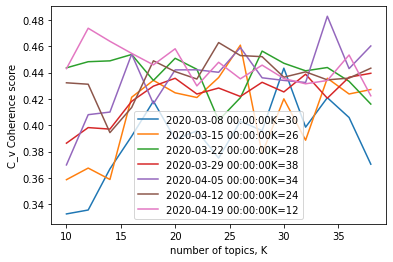

In [66]:
for date_iteration in date_iterations:
  coherence_values = date_iteration[6]
  start=10
  limit=40
  step=2
  x = range(start, limit, step)
  plt.plot(x, coherence_values, label=str(date_iteration[0]) + "K=" + str(date_iteration[8]))
  plt.xlabel("number of topics, K")
  plt.ylabel("C_v Coherence score")

plt.legend(loc='best')
plt.show()

In [0]:
# show change in coherence vs optimal # topics over time


In [0]:
%%time
model_list, coherence_values, perplexity_values, optimal_ntopics = find_num_topics(1, 40, 2, corpus, id2word)

In [0]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("CoherenceValues"), loc='best')
plt.show()



In [0]:
print(optimal_n_topics)

### Run LDA with the optimal number of topics 

In [0]:
texts = words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]

Optimal_lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=Optimal_N_Topic, 
                                       random_state=10,
                                       chunksize=100,
                                       passes=1,
                                       per_word_topics=True)

pprint(Optimal_lda_model.print_topics())
doc_lda = Optimal_lda_model[corpus]

## visualization
*pyLDAvis* is a python package to provide interactive web-based visualization to describe the topics that have been provided by the LDA model. 

In [0]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt



In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(Optimal_lda_model, corpus, id2word)
vis

# Run Search

In [0]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)


In [0]:
topics = Optimal_lda_model.print_topics(num_topics=Optimal_N_Topic, num_words=20)
topics = [topic[1] for topic in topics]
topics = [topic.split('"') for topic in topics]
search_inputs = [" ".join(topic_keys[1::2]) for topic_keys in topics]
search_inputs = [''.join([i if ord(i) < 128 else ' ' for i in text]) for text in search_inputs]

In [0]:
results_lda_df = search(search_inputs)

In [0]:
results_lda_df

## New Research Discovered through Context-aware search

The below results were all additional discoveries through the addition of NPI-context to the document search process that were not found with the baseline method.

In [0]:
common_results = np.intersect1d(results_df['title'].unique(), results_lda_df['title'].unique())
print("results in common: ", len(common_results))
common_results

In [0]:
print("Baseline average score: ", results_df['score'].mean())
print("NPI-Context average score: ", results_lda_df['score'].mean())

In [0]:
new_results = results_lda_df[~results_lda_df['title'].isin(results_df['title'].unique())]

print("Baseline # results: ", results_df['title'].nunique())
print("NPI-Context results: ", results_lda_df['title'].nunique())
print("New results above baseline: ", new_results['title'].nunique())

In [0]:
new_results.sample(4)

In [0]:
new_results['search'].unique()

In [0]:
new_results['title'].unique()